# Closer-to-Paper Reproduction (SMV SVM, PyTorch, No sklearn)

This notebook implements a **closer protocol match** to the paper:
- training corpus: 20 min speech + 20 min music
- test protocol: 4 sets (`varied`, `2s`, `5s`, `10s`)
- each set: 10 synthetic files, each with 15 alternating speech/music/silence segments
- baseline, filtering, skipping, and combined mechanisms
- paper-style normalized result tables

All outputs are rendered inline in the notebook.

## Fidelity Notes
Closer to paper:
- same high-level algorithm and evaluation protocol design
- 8 kHz, 20 ms frame-level features
- RBF SVM with `gamma=0.01`

Still approximate:
- dataset uses local MUSAN (paper used TIMIT + commercial CDs)
- SMV internal counters are approximated from available features
- no SimpleScalar energy simulator (we report SVM-call/time proxies)

In [1]:

import math
import random
import time
from dataclasses import dataclass
from pathlib import Path
from typing import Dict, List, Tuple
from IPython.display import display

import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 220)

In [2]:

# ===== Protocol Config =====
DATA_ROOT = Path('musan')
CACHE_ROOT = Path('artifacts/full_feature_cache')  # reuse feature cache already created earlier

FRAME_SEC = 0.02
SR = 8000

TRAIN_RATIO = 0.8
TRAIN_TOTAL_SEC_PER_CLASS = 20 * 60  # 20 min speech + 20 min music

# To keep exact dual SVM tractable after building 20-min corpus
TRAIN_STRIDE = 10
MAX_TRAIN_FRAMES_PER_CLASS = 5000

N_TEST_FILES_PER_SET = 10
N_SEGMENTS_PER_FILE = 15
TEST_MODES = ['varied', 2, 5, 10]

SVM_PARAMS = dict(C=2.0, gamma=0.01, lr=0.01, max_iter=800, tol=1e-5)

# Paper Table 5 parameters
FILTERING_PAPER = dict(eta_M=80.0, op='OR', eta_pr=6.0)
SKIPPING_PAPER = dict(skip_len=15, N=1, eta_speech=1, eta_music=1)
COMBINED_PAPER = dict(eta_M=80.0, op='OR', eta_pr=6.0, skip_len=16, N=1, eta_speech=1, eta_music=1)


## 1) Build File Index From Cached Features

In [3]:

assert DATA_ROOT.exists(), f'{DATA_ROOT} not found'
assert CACHE_ROOT.exists(), f'{CACHE_ROOT} not found. Run the full notebook once to create cache.'


def cache_path_for_audio(audio_path: Path) -> Path:
    rel = audio_path.relative_to(DATA_ROOT).with_suffix('')
    return CACHE_ROOT / (str(rel).replace('/', '__') + '.npy')


rows = []
for cls, label in [('speech', 1), ('music', -1), ('noise', 0)]:
    for p in sorted((DATA_ROOT / cls).rglob('*.wav')):
        cp = cache_path_for_audio(p)
        if not cp.exists():
            continue
        n = int(np.load(cp, mmap_mode='r').shape[0])
        rows.append({
            'path': str(p),
            'cache_path': str(cp),
            'label_name': cls,
            'label': label,
            'n_frames': n,
            'duration_sec': n * FRAME_SEC,
        })

index_df = pd.DataFrame(rows)
index_df.groupby('label_name', as_index=False).agg(files=('path', 'count'), hours=('duration_sec', lambda x: float(np.sum(x)/3600.0)))


,label_name,files,hours
0,music,660,42.612933
1,noise,930,6.224011
2,speech,426,60.447594


In [4]:

def split_paths(paths: List[str], ratio: float, seed: int) -> Tuple[List[str], List[str]]:
    rng = random.Random(seed)
    p = list(paths)
    rng.shuffle(p)
    n = int(len(p) * ratio)
    return p[:n], p[n:]

speech_paths = index_df[index_df.label == 1]['cache_path'].tolist()
music_paths = index_df[index_df.label == -1]['cache_path'].tolist()

train_speech, test_speech = split_paths(speech_paths, TRAIN_RATIO, SEED)
train_music, test_music = split_paths(music_paths, TRAIN_RATIO, SEED + 1)

print('Train speech files:', len(train_speech))
print('Train music files :', len(train_music))
print('Test speech files :', len(test_speech))
print('Test music files  :', len(test_music))


Train speech files: 340
Train music files : 528
Test speech files : 86
Test music files  : 132


## 2) Paper-Protocol Corpus Builder

In [5]:

rng = np.random.default_rng(SEED)


def sample_feature_chunk(file_list: List[str], frames: int) -> np.ndarray:
    """Sample contiguous feature chunk from random file in list."""
    for _ in range(120):
        cp = random.choice(file_list)
        x = np.load(cp)
        if x.shape[0] >= frames:
            st = int(rng.integers(0, x.shape[0] - frames + 1))
            return x[st:st + frames].astype(np.float32)

    cp = random.choice(file_list)
    x = np.load(cp)
    if x.shape[0] == 0:
        return np.zeros((frames, 6), dtype=np.float32)

    rep = int(np.ceil(frames / x.shape[0]))
    xx = np.vstack([x] * rep)
    st = int(rng.integers(0, xx.shape[0] - frames + 1))
    return xx[st:st + frames].astype(np.float32)


def build_training_corpus_20min(file_list: List[str], is_speech: bool, total_sec: float = TRAIN_TOTAL_SEC_PER_CLASS) -> np.ndarray:
    """
    Paper-like training corpus assembly:
    - speech segments: 6-12 sec
    - music segments : 28-30 sec
    until total duration reaches 20 minutes.
    """
    target_frames = int(round(total_sec / FRAME_SEC))
    out = []
    total = 0

    while total < target_frames:
        sec = random.uniform(6.0, 12.0) if is_speech else random.uniform(28.0, 30.0)
        fr = max(1, int(round(sec / FRAME_SEC)))
        chunk = sample_feature_chunk(file_list, fr)
        out.append(chunk)
        total += chunk.shape[0]

    return np.vstack(out)[:target_frames]


def build_test_file(mode) -> Tuple[np.ndarray, np.ndarray]:
    """
    One synthetic test file with 15 alternating speech/music/silence segments.
    - mode in {'varied',2,5,10}
    - silence: 0.5s for fixed modes; 3-15s for varied mode.
    """
    feats = []
    labels = []

    for _ in range(N_SEGMENTS_PER_FILE):
        if mode == 'varied':
            speech_sec = random.uniform(6.0, 12.0)
            music_sec = random.uniform(28.0, 30.0)
            silence_sec = random.uniform(3.0, 15.0)
        else:
            speech_sec = float(mode)
            music_sec = float(mode)
            silence_sec = 0.5

        sf = max(1, int(round(speech_sec / FRAME_SEC)))
        mf = max(1, int(round(music_sec / FRAME_SEC)))
        zf = max(1, int(round(silence_sec / FRAME_SEC)))

        speech_chunk = sample_feature_chunk(test_speech, sf)
        music_chunk = sample_feature_chunk(test_music, mf)
        silence_chunk = np.zeros((zf, 6), dtype=np.float32)

        feats.extend([speech_chunk, music_chunk, silence_chunk])
        labels.extend([np.ones(sf, dtype=np.int64), -np.ones(mf, dtype=np.int64), np.zeros(zf, dtype=np.int64)])

    return np.vstack(feats), np.concatenate(labels)


## 3) SVM (From Scratch)

In [6]:

class TorchRBFSVM:
    def __init__(self, C=2.0, gamma=0.01, lr=0.01, max_iter=800, tol=1e-5):
        self.C = C
        self.gamma = gamma
        self.lr = lr
        self.max_iter = max_iter
        self.tol = tol

    def _rbf(self, X1: torch.Tensor, X2: torch.Tensor) -> torch.Tensor:
        x1 = (X1 * X1).sum(dim=1, keepdim=True)
        x2 = (X2 * X2).sum(dim=1).unsqueeze(0)
        d2 = torch.clamp(x1 + x2 - 2.0 * (X1 @ X2.T), min=0.0)
        return torch.exp(-self.gamma * d2)

    def fit(self, X: np.ndarray, y: np.ndarray):
        X_t = torch.tensor(X, dtype=torch.float32)
        y_t = torch.tensor(y, dtype=torch.float32)

        K = self._rbf(X_t, X_t)
        Q = (y_t[:, None] * y_t[None, :]) * K

        alpha = torch.zeros(X_t.shape[0], dtype=torch.float32)
        y_norm = torch.dot(y_t, y_t)
        prev = -1e12

        for it in range(self.max_iter):
            grad = 1.0 - Q @ alpha
            alpha = torch.clamp(alpha + self.lr * grad, 0.0, self.C)
            alpha = alpha - y_t * (torch.dot(y_t, alpha) / (y_norm + 1e-8))
            alpha = torch.clamp(alpha, 0.0, self.C)

            if (it % 25 == 0) or (it == self.max_iter - 1):
                obj = torch.sum(alpha) - 0.5 * torch.dot(alpha, Q @ alpha)
                if abs((obj - prev).item()) < self.tol:
                    break
                prev = obj

        sv_mask = alpha > 1e-5
        self.sv = X_t[sv_mask].numpy().astype(np.float32)
        self.sv_y = y_t[sv_mask].numpy().astype(np.float32)
        self.alpha = alpha[sv_mask].numpy().astype(np.float32)
        self.alpha_y = self.alpha * self.sv_y

        if self.sv.shape[0] == 0:
            self.b = 0.0
            return

        margin = (alpha > 1e-5) & (alpha < self.C - 1e-5)
        if torch.any(margin):
            idx = torch.where(margin)[0][:256]
            b_vals = []
            for i in idx:
                k_col = K[sv_mask, i]
                fi = torch.sum(alpha[sv_mask] * y_t[sv_mask] * k_col)
                b_vals.append((y_t[i] - fi).item())
            self.b = float(np.mean(b_vals))
        else:
            dec = Q @ alpha
            self.b = float(torch.mean(y_t - dec).item())

    def decision_function(self, X: np.ndarray, batch: int = 512) -> np.ndarray:
        out = np.zeros((X.shape[0],), dtype=np.float32)
        if self.sv.shape[0] == 0:
            return out

        sv = self.sv
        ay = self.alpha_y
        sv2 = np.sum(sv * sv, axis=1)[None, :]

        for i in range(0, X.shape[0], batch):
            xb = X[i:i+batch]
            xb2 = np.sum(xb * xb, axis=1, keepdims=True)
            d2 = np.clip(xb2 + sv2 - 2.0 * (xb @ sv.T), 0.0, None)
            K = np.exp(-self.gamma * d2)
            out[i:i+batch] = K @ ay + self.b

        return out


## 4) Train 20-Minute/ Class Baseline SVM

In [7]:

X_speech_20m = build_training_corpus_20min(train_speech, is_speech=True, total_sec=TRAIN_TOTAL_SEC_PER_CLASS)
X_music_20m = build_training_corpus_20min(train_music, is_speech=False, total_sec=TRAIN_TOTAL_SEC_PER_CLASS)

print('20-min speech corpus frames:', X_speech_20m.shape[0])
print('20-min music corpus frames :', X_music_20m.shape[0])

# Subsample for exact dual optimization tractability
X_speech_train = X_speech_20m[::TRAIN_STRIDE][:MAX_TRAIN_FRAMES_PER_CLASS]
X_music_train = X_music_20m[::TRAIN_STRIDE][:MAX_TRAIN_FRAMES_PER_CLASS]

X_train_raw = np.vstack([X_speech_train, X_music_train]).astype(np.float32)
y_train = np.concatenate([
    np.ones(X_speech_train.shape[0], dtype=np.int64),
    -np.ones(X_music_train.shape[0], dtype=np.int64),
])

perm = np.random.permutation(len(y_train))
X_train_raw = X_train_raw[perm]
y_train = y_train[perm]

feat_mean = X_train_raw.mean(axis=0)
feat_std = X_train_raw.std(axis=0) + 1e-6
X_train = (X_train_raw - feat_mean) / feat_std

print('SVM train matrix:', X_train.shape)

svm = TorchRBFSVM(**SVM_PARAMS)
t0 = time.perf_counter()
svm.fit(X_train, y_train)
train_sec = time.perf_counter() - t0

print(f'train time: {train_sec:.2f}s')
print('support vectors:', len(svm.alpha))
print('bias b:', svm.b)


20-min speech corpus frames: 60000
20-min music corpus frames : 60000
SVM train matrix: (10000, 6)


train time: 6.14s
support vectors: 8424
bias b: 486.1954737082124


In [8]:

# Threshold calibration for SVM decision boundary (balanced-accuracy criterion on training set)
train_scores = svm.decision_function(X_train)

best_thr = 0.0
best_ba = -1.0
for thr in np.quantile(train_scores, np.linspace(0.01, 0.99, 99)):
    pred = np.where(train_scores >= thr, 1, -1)
    speech_rec = np.mean(pred[y_train == 1] == 1)
    music_rec = np.mean(pred[y_train == -1] == -1)
    ba = 0.5 * (speech_rec + music_rec)
    if ba > best_ba:
        best_ba = ba
        best_thr = float(thr)

print('chosen threshold:', best_thr)
print('train balanced accuracy:', best_ba)


chosen threshold: -44.436276245117185
train balanced accuracy: 0.544


## 5) Paper Mechanisms (Baseline, Filtering, Skipping, Combined)

In [9]:

def metrics_binary(y_true: np.ndarray, y_pred: np.ndarray) -> Dict[str, float]:
    m = y_true != 0
    yt = y_true[m]
    yp = y_pred[m]

    overall = float(np.mean(yp == yt))
    speech = float(np.mean(yp[yt == 1] == 1)) if np.any(yt == 1) else np.nan
    music = float(np.mean(yp[yt == -1] == -1)) if np.any(yt == -1) else np.nan

    return {'overall_acc': overall, 'speech_acc': speech, 'music_acc': music, 'n_eval': int(len(yt))}


def filtering_mask(raw: np.ndarray, eta_M: float, op: str, eta_pr: float) -> np.ndarray:
    cond_M = raw[:, 5] > eta_M
    cond_pr = raw[:, 4] > eta_pr
    return (cond_M & cond_pr) if op.upper() == 'AND' else (cond_M | cond_pr)


def run_filtering(raw: np.ndarray, baseline_pred: np.ndarray, eta_M: float, op: str, eta_pr: float):
    mask = filtering_mask(raw, eta_M, op, eta_pr)
    pred = baseline_pred.copy()
    pred[mask] = -1
    info = {'filtered': int(np.sum(mask)), 'skipped': 0, 'svm_calls': int(len(pred) - np.sum(mask))}
    return pred, info


def run_skipping(baseline_pred: np.ndarray, skip_len: int, N: int, eta_speech: int, eta_music: int):
    n = len(baseline_pred)
    pred = np.empty((n,), dtype=np.int64)

    hist = []
    nskip = 0
    cprev = 1
    skipped = 0
    svm_calls = 0

    for i in range(n):
        if nskip > 0:
            pred[i] = cprev
            skipped += 1
            nskip -= 1
            hist.append(cprev)
            continue

        y = int(baseline_pred[i])
        pred[i] = y
        svm_calls += 1
        hist.append(y)

        if len(hist) >= N:
            tail = hist[-N:]
            if tail.count(1) >= eta_speech:
                cprev = 1
                nskip = skip_len
            elif tail.count(-1) >= eta_music:
                cprev = -1
                nskip = skip_len

    info = {'filtered': 0, 'skipped': skipped, 'svm_calls': svm_calls}
    return pred, info


def run_combined(raw: np.ndarray, baseline_pred: np.ndarray,
                 eta_M: float, op: str, eta_pr: float,
                 skip_len: int, N: int, eta_speech: int, eta_music: int):
    n = len(baseline_pred)
    pred = np.empty((n,), dtype=np.int64)

    hist = []
    nskip = 0
    cprev = 1

    filtered = 0
    skipped = 0
    svm_calls = 0

    mask = filtering_mask(raw, eta_M, op, eta_pr)

    for i in range(n):
        if mask[i]:
            pred[i] = -1
            filtered += 1
            hist.append(-1)
            if nskip > 0:
                if cprev == 1:
                    nskip = 0
                else:
                    nskip = max(nskip - 1, 0)
            continue

        if nskip > 0:
            pred[i] = cprev
            skipped += 1
            nskip -= 1
            hist.append(cprev)
            continue

        y = int(baseline_pred[i])
        pred[i] = y
        svm_calls += 1
        hist.append(y)

        if len(hist) >= N:
            tail = hist[-N:]
            if tail.count(1) >= eta_speech:
                cprev = 1
                nskip = skip_len
            elif tail.count(-1) >= eta_music:
                cprev = -1
                nskip = skip_len

    info = {'filtered': filtered, 'skipped': skipped, 'svm_calls': svm_calls}
    return pred, info


## 6) Build Paper Test Sets (4 Modes x 10 Files)

In [10]:

paper_test_sets = {}
for mode in TEST_MODES:
    files = []
    for k in range(N_TEST_FILES_PER_SET):
        raw, y = build_test_file(mode)
        files.append({'raw': raw, 'y_true': y, 'mode': str(mode), 'file_id': k})
    paper_test_sets[str(mode)] = files

for mode, files in paper_test_sets.items():
    total_frames = int(sum(len(f['y_true']) for f in files))
    eval_frames = int(sum(np.sum(f['y_true'] != 0) for f in files))
    print(mode, 'files=', len(files), 'total_frames=', total_frames, 'eval_frames=', eval_frames)


varied files= 10 total_frames= 352539 eval_frames= 286030
2 files= 10 total_frames= 33750 eval_frames= 30000
5 files= 10 total_frames= 78750 eval_frames= 75000
10 files= 10 total_frames= 153750 eval_frames= 150000


In [11]:

# Precompute baseline predictions per synthetic file (for fair method comparisons)
baseline_cache = {}
baseline_times = []

for mode, files in paper_test_sets.items():
    for f in files:
        key = (mode, f['file_id'])
        Xn = (f['raw'] - feat_mean) / feat_std

        t0 = time.perf_counter()
        scores = svm.decision_function(Xn)
        elapsed = time.perf_counter() - t0
        pred = np.where(scores >= best_thr, 1, -1).astype(np.int64)

        baseline_cache[key] = {'scores': scores, 'pred': pred}
        baseline_times.append((elapsed, len(pred)))

baseline_ms_per_frame = 1000.0 * (sum(t for t, n in baseline_times) / sum(n for t, n in baseline_times))
print('baseline measured ms/frame (paper synthetic sets):', baseline_ms_per_frame)


baseline measured ms/frame (paper synthetic sets): 0.04768821515249977


## 7) Main Paper-Style Results

In [12]:

def evaluate_all_modes(method_name: str, params: dict) -> pd.DataFrame:
    rows = []

    for mode, files in paper_test_sets.items():
        for f in files:
            key = (mode, f['file_id'])
            raw = f['raw']
            y_true = f['y_true']
            base_pred = baseline_cache[key]['pred']

            if method_name == 'Baseline':
                y_pred = base_pred
                info = {'filtered': 0, 'skipped': 0, 'svm_calls': len(base_pred)}
            elif method_name == 'Filtering':
                y_pred, info = run_filtering(raw, base_pred, **params)
            elif method_name == 'Skipping':
                y_pred, info = run_skipping(base_pred, **params)
            elif method_name == 'Combined':
                y_pred, info = run_combined(raw, base_pred, **params)
            else:
                raise ValueError(method_name)

            m = metrics_binary(y_true, y_pred)
            total = len(y_true)

            rows.append({
                'mode': mode,
                'file_id': f['file_id'],
                'method': method_name,
                **m,
                'filtered_ratio': info['filtered'] / total,
                'skipped_ratio': info['skipped'] / total,
                'overall_ratio': (info['filtered'] + info['skipped']) / total,
                'svm_call_ratio': info['svm_calls'] / total,
            })

    return pd.DataFrame(rows)


main_results = []
main_results.append(evaluate_all_modes('Baseline', {}))
main_results.append(evaluate_all_modes('Filtering', FILTERING_PAPER))
main_results.append(evaluate_all_modes('Skipping', SKIPPING_PAPER))
main_results.append(evaluate_all_modes('Combined', COMBINED_PAPER))

paper_results_raw = pd.concat(main_results, ignore_index=True)
paper_results_raw.head()


,mode,file_id,method,overall_acc,speech_acc,music_acc,n_eval,filtered_ratio,skipped_ratio,overall_ratio,svm_call_ratio
0,varied,0,Baseline,0.371764,0.874694,0.220802,28276,0.0,0.0,0.0,1.0
1,varied,1,Baseline,0.337911,0.963667,0.149879,28469,0.0,0.0,0.0,1.0
2,varied,2,Baseline,0.297304,0.970342,0.099370,28338,0.0,0.0,0.0,1.0
3,varied,3,Baseline,0.386865,0.863422,0.232841,28687,0.0,0.0,0.0,1.0
4,varied,4,Baseline,0.371007,0.875940,0.214436,28641,0.0,0.0,0.0,1.0


In [13]:

paper_results_mean = (
    paper_results_raw
    .groupby(['mode', 'method'], as_index=False)[['overall_acc', 'speech_acc', 'music_acc', 'filtered_ratio', 'skipped_ratio', 'overall_ratio', 'svm_call_ratio']]
    .mean()
)
paper_results_mean


,mode,method,overall_acc,speech_acc,music_acc,filtered_ratio,skipped_ratio,overall_ratio,svm_call_ratio
0,10,Baseline,0.525140,0.904147,0.146133,0.000000,0.000000,0.000000,1.000000
1,10,Combined,0.499333,0.000000,0.998667,0.974959,0.023050,0.998010,0.001990
2,10,Filtering,0.499333,0.000000,0.998667,0.974959,0.000000,0.974959,0.025041
3,10,Skipping,0.522827,0.899240,0.146413,0.000000,0.937496,0.937496,0.062504
4,2,Baseline,0.535500,0.915600,0.155400,0.000000,0.000000,0.000000,1.000000
5,2,Combined,0.500000,0.000000,1.000000,0.888889,0.102222,0.991111,0.008889
6,2,Filtering,0.500000,0.000000,1.000000,0.888889,0.000000,0.888889,0.111111
7,2,Skipping,0.532100,0.918267,0.145933,0.000000,0.937481,0.937481,0.062519
8,5,Baseline,0.528827,0.910933,0.146720,0.000000,0.000000,0.000000,1.000000
9,5,Combined,0.500000,0.000000,1.000000,0.952381,0.043810,0.996190,0.003810


In [14]:

# Paper-style normalized accuracies to baseline (per mode)
norm_rows = []
for mode, g in paper_results_mean.groupby('mode'):
    b = g[g['method'] == 'Baseline'].iloc[0]
    for _, r in g.iterrows():
        norm_rows.append({
            'mode': mode,
            'method': r['method'],
            'overall_norm': r['overall_acc'] / b['overall_acc'],
            'speech_norm': r['speech_acc'] / b['speech_acc'],
            'music_norm': r['music_acc'] / b['music_acc'],
            'filtered_ratio': r['filtered_ratio'],
            'skipped_ratio': r['skipped_ratio'],
            'overall_ratio': r['overall_ratio'],
            'svm_call_ratio': r['svm_call_ratio'],
        })

paper_results_norm = pd.DataFrame(norm_rows)
paper_results_norm


,mode,method,overall_norm,speech_norm,music_norm,filtered_ratio,skipped_ratio,overall_ratio,svm_call_ratio
0,10,Baseline,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
1,10,Combined,0.950858,0.000000,6.833942,0.974959,0.023050,0.998010,0.001990
2,10,Filtering,0.950858,0.000000,6.833942,0.974959,0.000000,0.974959,0.025041
3,10,Skipping,0.995595,0.994573,1.001916,0.000000,0.937496,0.937496,0.062504
4,2,Baseline,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
5,2,Combined,0.933707,0.000000,6.435006,0.888889,0.102222,0.991111,0.008889
6,2,Filtering,0.933707,0.000000,6.435006,0.888889,0.000000,0.888889,0.111111
7,2,Skipping,0.993651,1.002912,0.939082,0.000000,0.937481,0.937481,0.062519
8,5,Baseline,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
9,5,Combined,0.945489,0.000000,6.815703,0.952381,0.043810,0.996190,0.003810


In [15]:

# Table 6-like aggregate over all modes
agg = (
    paper_results_norm
    .groupby('method', as_index=False)[['overall_norm', 'speech_norm', 'music_norm', 'overall_ratio', 'svm_call_ratio']]
    .mean()
)
agg['estimated_exec_ms_per_frame'] = baseline_ms_per_frame * agg['svm_call_ratio']

paper_table6_like = agg[['method', 'overall_norm', 'speech_norm', 'music_norm', 'overall_ratio', 'estimated_exec_ms_per_frame']]
paper_table6_like


,method,overall_norm,speech_norm,music_norm,overall_ratio,estimated_exec_ms_per_frame
0,Baseline,1.000000,1.000000,1.000000,0.000000,0.047688
1,Combined,1.273185,0.000012,6.591547,0.993502,0.000310
2,Filtering,1.273185,0.000012,6.591547,0.906947,0.004438
3,Skipping,1.003746,1.001962,0.994345,0.937465,0.002982


## 8) Filtering Sweep (Paper Triplets)

In [16]:

paper_triplets = [
    (80, 'AND', 4),
    (70, 'AND', 2),
    (80, 'OR', 6),
    (60, 'OR', 4),
    (30, 'AND', 1),
    (40, 'OR', 2),
]

rows = []
for eta_M, op, eta_pr in paper_triplets:
    df = evaluate_all_modes('Filtering', dict(eta_M=float(eta_M), op=op, eta_pr=float(eta_pr)))
    m = df.groupby('mode', as_index=False)[['overall_acc', 'speech_acc', 'music_acc', 'filtered_ratio']].mean()
    m['triplet'] = f'{{{eta_M}, {op}, {eta_pr}}}'
    rows.append(m)

filtering_sweep = pd.concat(rows, ignore_index=True)
filtering_sweep


,mode,overall_acc,speech_acc,music_acc,filtered_ratio,triplet
0,10,0.499280,0.000840,0.997720,0.974088,"{80, AND, 4}"
1,2,0.502033,0.004067,1.000000,0.887081,"{80, AND, 4}"
2,5,0.500667,0.001760,0.999573,0.951340,"{80, AND, 4}"
3,varied,0.762352,0.003908,1.000000,0.810818,"{80, AND, 4}"
4,10,0.499480,0.000707,0.998253,0.974413,"{70, AND, 2}"
5,2,0.501567,0.003133,1.000000,0.887496,"{70, AND, 2}"
6,5,0.500613,0.001360,0.999867,0.951670,"{70, AND, 2}"
7,varied,0.762176,0.003163,1.000000,0.810959,"{70, AND, 2}"
8,10,0.499333,0.000000,0.998667,0.974959,"{80, OR, 6}"
9,2,0.500000,0.000000,1.000000,0.888889,"{80, OR, 6}"


## 9) Skipping Sensitivity (N and skip_len)

In [17]:

skip_lengths = [8, 16, 32]
N_values = [1, 4, 16]

rows = []
for sl in skip_lengths:
    for N in N_values:
        params = dict(skip_len=sl, N=N, eta_speech=N, eta_music=N)
        df = evaluate_all_modes('Skipping', params)
        m = df.groupby('mode', as_index=False)[['overall_acc', 'speech_acc', 'music_acc', 'overall_ratio']].mean()
        m['skip_len'] = sl
        m['N'] = N
        rows.append(m)

skipping_sweep = pd.concat(rows, ignore_index=True)
skipping_sweep


,mode,overall_acc,speech_acc,music_acc,overall_ratio,skip_len,N
0,10,0.524293,0.903920,0.144667,0.888846,8,1
1,2,0.534133,0.915133,0.153133,0.888889,8,1
2,5,0.528933,0.911653,0.146213,0.888889,8,1
3,varied,0.336613,0.902371,0.159546,0.888878,8,1
4,10,0.529873,0.913000,0.146747,0.858218,8,4
5,2,0.538033,0.924333,0.151733,0.860652,8,4
6,5,0.531773,0.917333,0.146213,0.859568,8,4
7,varied,0.337217,0.908195,0.158485,0.865042,8,4
8,10,0.532620,0.921813,0.143427,0.772820,8,16
9,2,0.536900,0.930867,0.142933,0.764296,8,16


## 10) Inline Visual Analysis

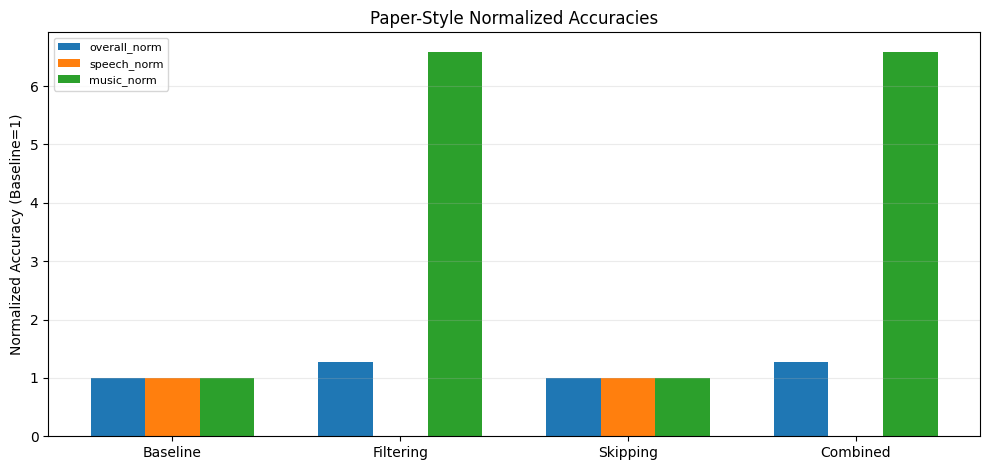

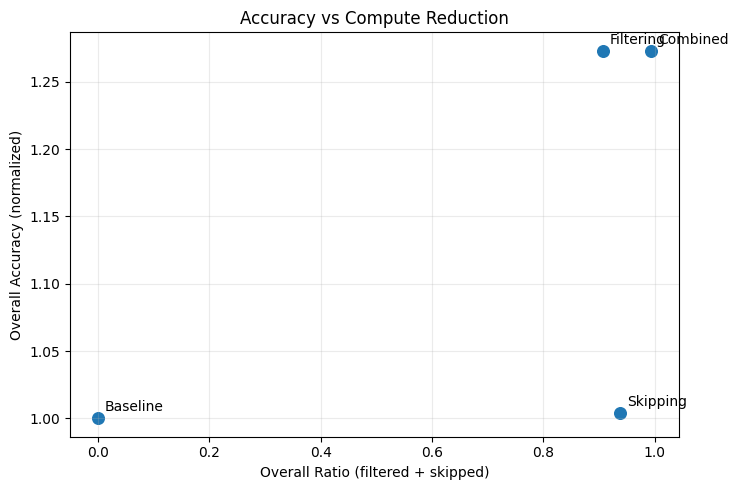

In [18]:

# A) Main normalized comparison (Table 6-like)
plot_df = paper_table6_like.copy()
order = ['Baseline', 'Filtering', 'Skipping', 'Combined']
plot_df['method'] = pd.Categorical(plot_df['method'], categories=order, ordered=True)
plot_df = plot_df.sort_values('method')

fig, ax = plt.subplots(figsize=(10, 4.8))
metrics = ['overall_norm', 'speech_norm', 'music_norm']
x = np.arange(len(plot_df))
width = 0.24
for i, m in enumerate(metrics):
    ax.bar(x + (i - 1) * width, plot_df[m].values, width=width, label=m)
ax.set_xticks(x)
ax.set_xticklabels(plot_df['method'])
ax.set_ylabel('Normalized Accuracy (Baseline=1)')
ax.set_title('Paper-Style Normalized Accuracies')
ax.grid(axis='y', alpha=0.25)
ax.legend(fontsize=8)
plt.tight_layout()
plt.show()

# B) Compute reduction vs normalized overall accuracy
fig, ax = plt.subplots(figsize=(7.5, 5))
ax.scatter(plot_df['overall_ratio'], plot_df['overall_norm'], s=70)
for _, r in plot_df.iterrows():
    ax.annotate(r['method'], (r['overall_ratio'], r['overall_norm']), xytext=(5, 5), textcoords='offset points')
ax.set_xlabel('Overall Ratio (filtered + skipped)')
ax.set_ylabel('Overall Accuracy (normalized)')
ax.set_title('Accuracy vs Compute Reduction')
ax.grid(alpha=0.25)
plt.tight_layout()
plt.show()


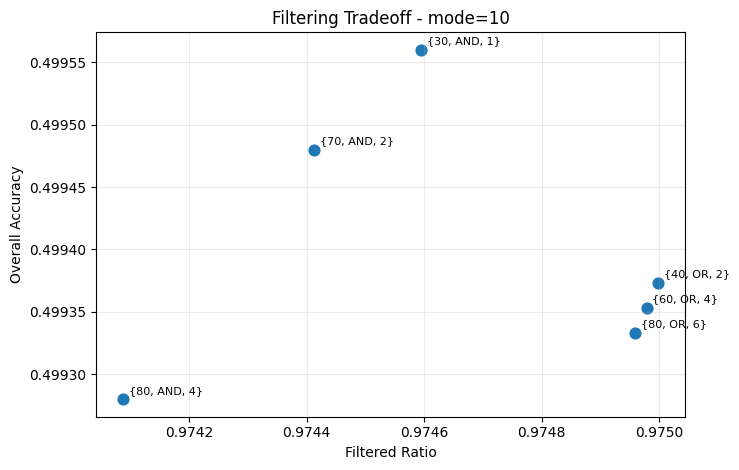

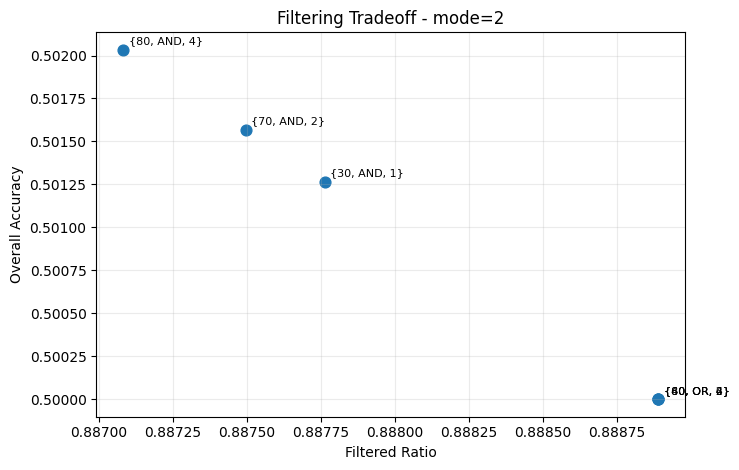

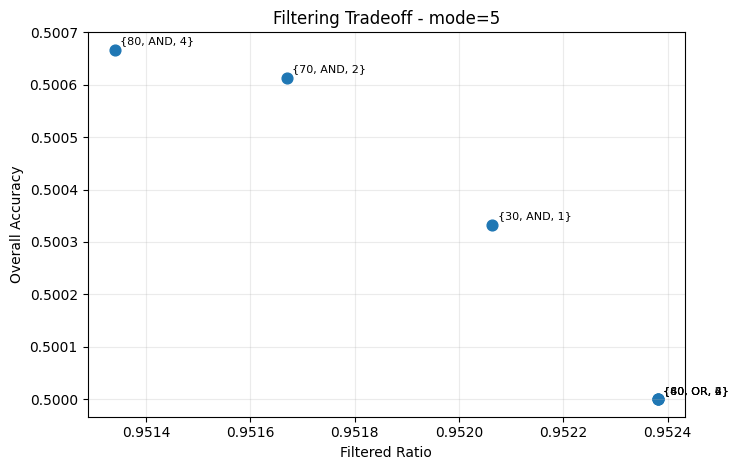

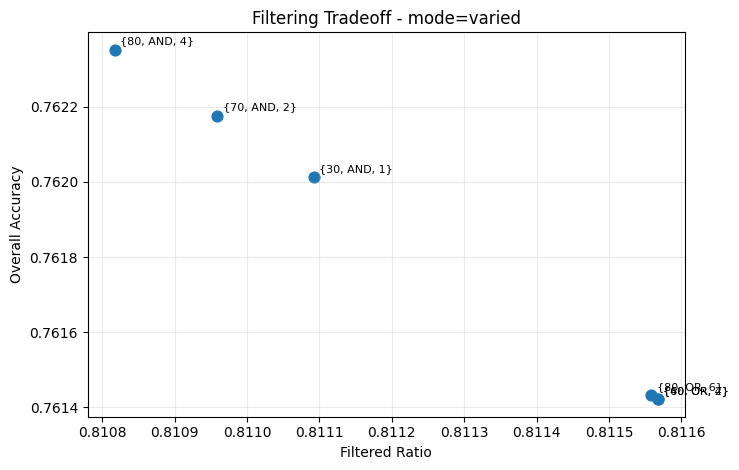

In [19]:

# C) Filtering triplet tradeoff on each mode
for mode in sorted(filtering_sweep['mode'].unique(), key=lambda x: str(x)):
    d = filtering_sweep[filtering_sweep['mode'] == mode]
    fig, ax = plt.subplots(figsize=(7.5, 4.8))
    ax.scatter(d['filtered_ratio'], d['overall_acc'], s=60)
    for _, r in d.iterrows():
        ax.annotate(r['triplet'], (r['filtered_ratio'], r['overall_acc']), xytext=(4, 4), textcoords='offset points', fontsize=8)
    ax.set_title(f'Filtering Tradeoff - mode={mode}')
    ax.set_xlabel('Filtered Ratio')
    ax.set_ylabel('Overall Accuracy')
    ax.grid(alpha=0.25)
    plt.tight_layout()
    plt.show()


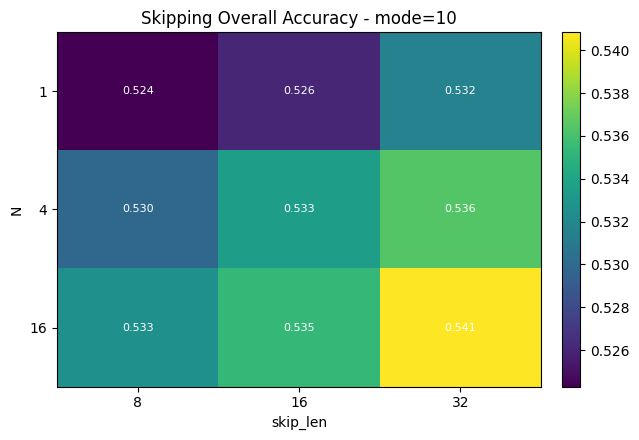

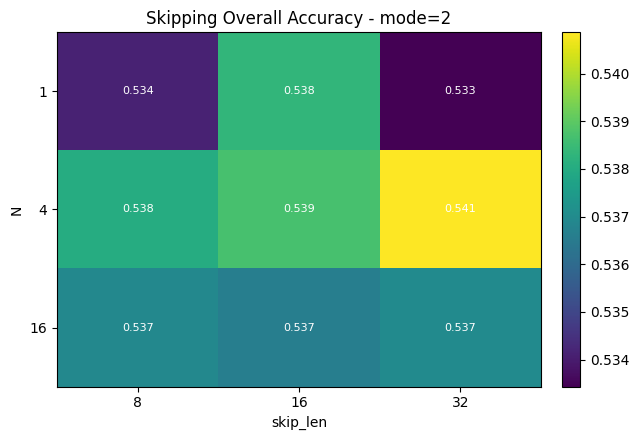

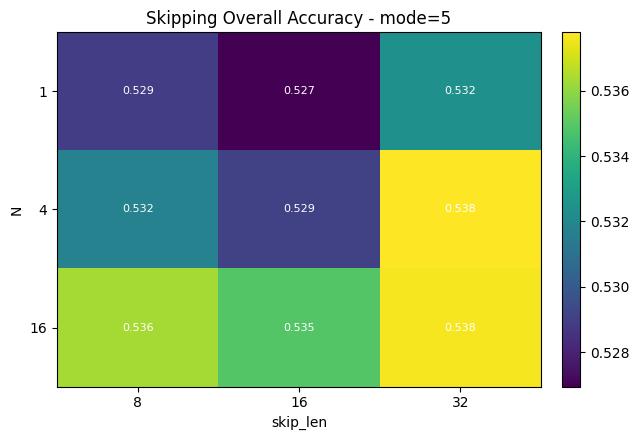

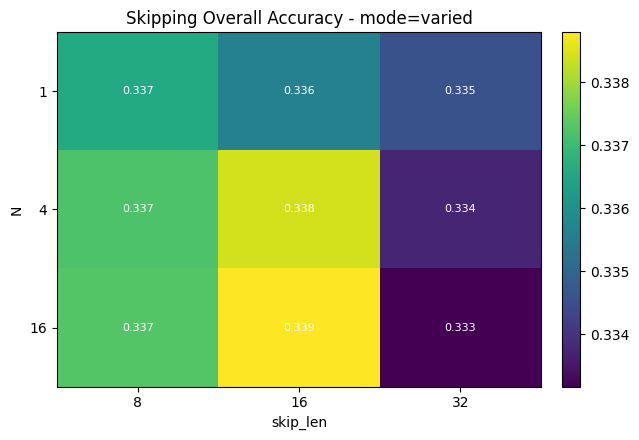

In [20]:

# D) Skipping heatmap of overall accuracy (per mode)
for mode in sorted(skipping_sweep['mode'].unique(), key=lambda x: str(x)):
    d = skipping_sweep[skipping_sweep['mode'] == mode]
    piv = d.pivot(index='N', columns='skip_len', values='overall_acc').sort_index().sort_index(axis=1)

    fig, ax = plt.subplots(figsize=(6.5, 4.5))
    im = ax.imshow(piv.values, aspect='auto', cmap='viridis')
    ax.set_xticks(range(len(piv.columns)))
    ax.set_xticklabels(piv.columns)
    ax.set_yticks(range(len(piv.index)))
    ax.set_yticklabels(piv.index)
    ax.set_xlabel('skip_len')
    ax.set_ylabel('N')
    ax.set_title(f'Skipping Overall Accuracy - mode={mode}')

    for i in range(piv.shape[0]):
        for j in range(piv.shape[1]):
            ax.text(j, i, f"{piv.values[i, j]:.3f}", ha='center', va='center', color='white', fontsize=8)

    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()


## 11) Interpretation
- `paper_table6_like` is the closest analog to paper Table 6 under this dataset/proxy setup.
- `paper_results_norm` provides per-mode normalized accuracies.
- `filtering_sweep` and `skipping_sweep` mirror sensitivity analyses in Sections 5.2 and 5.3.

## 12) Full Metrics Engine (From Scratch, No sklearn)
This section adds complete classification metrics implemented manually in NumPy:
- confusion counts (`TP/TN/FP/FN`)
- precision, recall, F1 (speech/music, macro, weighted)
- balanced accuracy, MCC, Cohen's kappa
- ROC-AUC and PR-AUC (from decision scores)

In [21]:
FEATURE_NAMES = ['r_energy', 'r_rc', 'r_res', 'r_npc', 'c_pr', 'c_M']
METHOD_ORDER = ['Baseline', 'Filtering', 'Skipping', 'Combined']


def safe_div(num: float, den: float) -> float:
    return float(num / den) if den != 0 else float('nan')


def f1_from_pr(precision: float, recall: float) -> float:
    if np.isnan(precision) or np.isnan(recall) or (precision + recall) == 0:
        return float('nan')
    return float(2.0 * precision * recall / (precision + recall))


def confusion_counts(y_true: np.ndarray, y_pred: np.ndarray) -> Tuple[int, int, int, int]:
    tp = int(np.sum((y_true == 1) & (y_pred == 1)))
    tn = int(np.sum((y_true == -1) & (y_pred == -1)))
    fp = int(np.sum((y_true == -1) & (y_pred == 1)))
    fn = int(np.sum((y_true == 1) & (y_pred == -1)))
    return tp, tn, fp, fn


def roc_pr_curve_from_scores(y_true: np.ndarray, scores: np.ndarray) -> Dict[str, np.ndarray]:
    y_bin = (y_true == 1).astype(np.int64)
    P = int(np.sum(y_bin == 1))
    N = int(np.sum(y_bin == 0))

    if P == 0 or N == 0:
        return {
            'fpr': np.array([0.0, 1.0]),
            'tpr': np.array([0.0, 1.0]),
            'precision': np.array([1.0]),
            'recall': np.array([0.0]),
            'roc_auc': np.nan,
            'pr_auc': np.nan,
        }

    order = np.argsort(-scores, kind='mergesort')
    y_sorted = y_bin[order]
    s_sorted = scores[order]

    tp = np.cumsum(y_sorted == 1).astype(np.float64)
    fp = np.cumsum(y_sorted == 0).astype(np.float64)

    distinct = np.where(np.diff(s_sorted) != 0)[0]
    idx = np.r_[distinct, len(s_sorted) - 1]

    tp_u = tp[idx]
    fp_u = fp[idx]

    tpr = tp_u / P
    fpr = fp_u / N

    roc_tpr = np.r_[0.0, tpr, 1.0]
    roc_fpr = np.r_[0.0, fpr, 1.0]
    roc_auc = float(np.trapezoid(roc_tpr, roc_fpr))

    precision = tp_u / np.maximum(tp_u + fp_u, 1.0)
    recall = tpr

    pr_recall = np.r_[0.0, recall]
    pr_precision = np.r_[1.0, precision]
    pr_auc = float(np.trapezoid(pr_precision, pr_recall))

    return {
        'fpr': roc_fpr,
        'tpr': roc_tpr,
        'precision': pr_precision,
        'recall': pr_recall,
        'roc_auc': roc_auc,
        'pr_auc': pr_auc,
    }


def binary_metrics_full(y_true: np.ndarray, y_pred: np.ndarray, scores: np.ndarray = None, return_curves: bool = False):
    mask = (y_true == 1) | (y_true == -1)
    yt = y_true[mask]
    yp = y_pred[mask]

    if len(yt) == 0:
        empty = {
            'n_eval': 0,
            'tp': 0, 'tn': 0, 'fp': 0, 'fn': 0,
            'accuracy': np.nan,
            'balanced_accuracy': np.nan,
            'precision_speech': np.nan,
            'recall_speech': np.nan,
            'f1_speech': np.nan,
            'precision_music': np.nan,
            'recall_music': np.nan,
            'f1_music': np.nan,
            'macro_precision': np.nan,
            'macro_recall': np.nan,
            'macro_f1': np.nan,
            'weighted_f1': np.nan,
            'mcc': np.nan,
            'kappa': np.nan,
            'roc_auc': np.nan,
            'pr_auc': np.nan,
        }
        return (empty, None) if return_curves else empty

    tp, tn, fp, fn = confusion_counts(yt, yp)
    n = tp + tn + fp + fn

    precision_speech = safe_div(tp, tp + fp)
    recall_speech = safe_div(tp, tp + fn)
    f1_speech = f1_from_pr(precision_speech, recall_speech)

    precision_music = safe_div(tn, tn + fn)
    recall_music = safe_div(tn, tn + fp)
    f1_music = f1_from_pr(precision_music, recall_music)

    accuracy = safe_div(tp + tn, n)
    balanced_accuracy = np.nanmean([recall_speech, recall_music])
    macro_precision = np.nanmean([precision_speech, precision_music])
    macro_recall = np.nanmean([recall_speech, recall_music])
    macro_f1 = np.nanmean([f1_speech, f1_music])

    support_speech = tp + fn
    support_music = tn + fp
    weighted_f1 = safe_div(f1_speech * support_speech + f1_music * support_music, max(n, 1))

    mcc_num = (tp * tn) - (fp * fn)
    mcc_den = math.sqrt(max((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn), 0))
    mcc = safe_div(mcc_num, mcc_den)

    po = accuracy
    pe = safe_div((tp + fp) * (tp + fn) + (fn + tn) * (fp + tn), n * n)
    kappa = safe_div(po - pe, 1.0 - pe) if not np.isnan(pe) else np.nan

    curve = None
    roc_auc = np.nan
    pr_auc = np.nan
    if scores is not None:
        sc = scores[mask]
        curve = roc_pr_curve_from_scores(yt, sc)
        roc_auc = curve['roc_auc']
        pr_auc = curve['pr_auc']

    out = {
        'n_eval': int(n),
        'tp': int(tp), 'tn': int(tn), 'fp': int(fp), 'fn': int(fn),
        'accuracy': float(accuracy),
        'balanced_accuracy': float(balanced_accuracy),
        'precision_speech': float(precision_speech),
        'recall_speech': float(recall_speech),
        'f1_speech': float(f1_speech),
        'precision_music': float(precision_music),
        'recall_music': float(recall_music),
        'f1_music': float(f1_music),
        'macro_precision': float(macro_precision),
        'macro_recall': float(macro_recall),
        'macro_f1': float(macro_f1),
        'weighted_f1': float(weighted_f1),
        'mcc': float(mcc),
        'kappa': float(kappa),
        'roc_auc': float(roc_auc),
        'pr_auc': float(pr_auc),
    }

    if return_curves:
        return out, curve
    return out

## 13) Detailed Paper-Protocol Metrics (Per File / Per Mode / Overall)
This computes full metrics for each method using the same synthetic paper protocol.

In [22]:
def evaluate_method_detailed_on_paper(method_name: str, params: dict):
    file_rows = []
    mode_rows = []
    mode_curves = {}

    mode_store = {}
    for mode in paper_test_sets.keys():
        mode_store[mode] = {
            'y': [],
            'pred': [],
            'scores': [],
            'filtered': 0,
            'skipped': 0,
            'svm_calls': 0,
            'total': 0,
        }

    all_y = []
    all_pred = []
    all_scores = []
    total_filtered = 0
    total_skipped = 0
    total_svm_calls = 0
    total_frames = 0

    for mode, files in paper_test_sets.items():
        for f in files:
            key = (mode, f['file_id'])
            raw = f['raw']
            y_true = f['y_true']
            baseline_scores = baseline_cache[key]['scores']
            baseline_pred = baseline_cache[key]['pred']

            if method_name == 'Baseline':
                y_pred = baseline_pred
                info = {'filtered': 0, 'skipped': 0, 'svm_calls': len(y_pred)}
                score_for_auc = baseline_scores
            elif method_name == 'Filtering':
                y_pred, info = run_filtering(raw, baseline_pred, **params)
                score_for_auc = None
            elif method_name == 'Skipping':
                y_pred, info = run_skipping(baseline_pred, **params)
                score_for_auc = None
            elif method_name == 'Combined':
                y_pred, info = run_combined(raw, baseline_pred, **params)
                score_for_auc = None
            else:
                raise ValueError(method_name)

            total = len(y_true)
            met = binary_metrics_full(y_true, y_pred, scores=score_for_auc)

            file_rows.append({
                'mode': mode,
                'file_id': f['file_id'],
                'method': method_name,
                **met,
                'filtered_ratio': info['filtered'] / max(total, 1),
                'skipped_ratio': info['skipped'] / max(total, 1),
                'overall_ratio': (info['filtered'] + info['skipped']) / max(total, 1),
                'svm_call_ratio': info['svm_calls'] / max(total, 1),
            })

            m = (y_true != 0)
            mode_store[mode]['y'].append(y_true[m])
            mode_store[mode]['pred'].append(y_pred[m])
            if score_for_auc is not None:
                mode_store[mode]['scores'].append(score_for_auc[m])

            mode_store[mode]['filtered'] += int(info['filtered'])
            mode_store[mode]['skipped'] += int(info['skipped'])
            mode_store[mode]['svm_calls'] += int(info['svm_calls'])
            mode_store[mode]['total'] += int(total)

            all_y.append(y_true[m])
            all_pred.append(y_pred[m])
            if score_for_auc is not None:
                all_scores.append(score_for_auc[m])

            total_filtered += int(info['filtered'])
            total_skipped += int(info['skipped'])
            total_svm_calls += int(info['svm_calls'])
            total_frames += int(total)

    for mode in paper_test_sets.keys():
        yt = np.concatenate(mode_store[mode]['y'])
        yp = np.concatenate(mode_store[mode]['pred'])
        sc = np.concatenate(mode_store[mode]['scores']) if len(mode_store[mode]['scores']) > 0 else None

        met, curve = binary_metrics_full(yt, yp, scores=sc, return_curves=True)
        mode_curves[mode] = curve

        mode_rows.append({
            'mode': mode,
            'method': method_name,
            **met,
            'filtered_ratio': mode_store[mode]['filtered'] / max(mode_store[mode]['total'], 1),
            'skipped_ratio': mode_store[mode]['skipped'] / max(mode_store[mode]['total'], 1),
            'overall_ratio': (mode_store[mode]['filtered'] + mode_store[mode]['skipped']) / max(mode_store[mode]['total'], 1),
            'svm_call_ratio': mode_store[mode]['svm_calls'] / max(mode_store[mode]['total'], 1),
        })

    yt_all = np.concatenate(all_y)
    yp_all = np.concatenate(all_pred)
    sc_all = np.concatenate(all_scores) if len(all_scores) > 0 else None
    overall_met, overall_curve = binary_metrics_full(yt_all, yp_all, scores=sc_all, return_curves=True)

    overall_row = {
        'method': method_name,
        **overall_met,
        'filtered_ratio': total_filtered / max(total_frames, 1),
        'skipped_ratio': total_skipped / max(total_frames, 1),
        'overall_ratio': (total_filtered + total_skipped) / max(total_frames, 1),
        'svm_call_ratio': total_svm_calls / max(total_frames, 1),
    }

    return pd.DataFrame(file_rows), pd.DataFrame(mode_rows), overall_row, mode_curves, overall_curve


paper_method_params = {
    'Baseline': {},
    'Filtering': FILTERING_PAPER,
    'Skipping': SKIPPING_PAPER,
    'Combined': COMBINED_PAPER,
}

paper_file_parts = []
paper_mode_parts = []
paper_overall_rows = []
paper_mode_curves_by_method = {}
paper_overall_curves_by_method = {}

for method in METHOD_ORDER:
    f_df, m_df, o_row, m_curves, o_curve = evaluate_method_detailed_on_paper(method, paper_method_params[method])
    paper_file_parts.append(f_df)
    paper_mode_parts.append(m_df)
    paper_overall_rows.append(o_row)
    paper_mode_curves_by_method[method] = m_curves
    paper_overall_curves_by_method[method] = o_curve

paper_file_metrics_full = pd.concat(paper_file_parts, ignore_index=True)
paper_mode_metrics_full = pd.concat(paper_mode_parts, ignore_index=True)
paper_overall_metrics_full = pd.DataFrame(paper_overall_rows)

paper_overall_metrics_full['method'] = pd.Categorical(paper_overall_metrics_full['method'], categories=METHOD_ORDER, ordered=True)
paper_overall_metrics_full = paper_overall_metrics_full.sort_values('method').reset_index(drop=True)

# Normalized view versus baseline for key quality metrics
base_row = paper_overall_metrics_full[paper_overall_metrics_full['method'] == 'Baseline'].iloc[0]
norm_cols = ['accuracy', 'balanced_accuracy', 'macro_f1', 'weighted_f1', 'recall_speech', 'recall_music']
paper_overall_norm_full = paper_overall_metrics_full[['method', 'overall_ratio', 'svm_call_ratio']].copy()
for c in norm_cols:
    denom = float(base_row[c]) if float(base_row[c]) != 0 else np.nan
    paper_overall_norm_full[f'{c}_norm'] = paper_overall_metrics_full[c] / denom

print('Detailed paper-protocol metrics built.')
print('Per-file rows:', len(paper_file_metrics_full))
print('Per-mode rows:', len(paper_mode_metrics_full))
paper_overall_metrics_full[['method', 'accuracy', 'balanced_accuracy', 'macro_f1', 'weighted_f1', 'recall_speech', 'recall_music', 'mcc', 'kappa', 'roc_auc', 'pr_auc', 'overall_ratio', 'svm_call_ratio']]

Detailed paper-protocol metrics built.
Per-file rows: 160
Per-mode rows: 16


,method,accuracy,balanced_accuracy,macro_f1,weighted_f1,recall_speech,recall_music,mcc,kappa,roc_auc,pr_auc,overall_ratio,svm_call_ratio
0,Baseline,0.426492,0.530250,0.394787,0.356504,0.905677,0.154823,0.085630,0.046453,0.450228,0.322178,0.000000,1.000000
1,Filtering,0.638007,0.499863,0.389517,0.497160,0.000015,0.999710,-0.009554,-0.000350,NaN,NaN,0.874170,0.125830
2,Skipping,0.429660,0.532808,0.398971,0.361436,0.906029,0.159587,0.092026,0.050450,NaN,NaN,0.937476,0.062524
3,Combined,0.638007,0.499863,0.389517,0.497160,0.000015,0.999710,-0.009554,-0.000350,NaN,NaN,0.992088,0.007912


In [23]:
# Additional per-mode and per-file views
paper_mode_metrics_view = paper_mode_metrics_full[
    ['mode', 'method', 'accuracy', 'balanced_accuracy', 'macro_f1', 'weighted_f1', 'recall_speech', 'recall_music', 'mcc', 'overall_ratio', 'svm_call_ratio']
].copy()

paper_mode_metrics_view['method'] = pd.Categorical(paper_mode_metrics_view['method'], categories=METHOD_ORDER, ordered=True)
paper_mode_metrics_view = paper_mode_metrics_view.sort_values(['mode', 'method']).reset_index(drop=True)

print('Paper protocol per-mode metrics (full):')
display(paper_mode_metrics_view)

print('Paper protocol normalized summary:')
display(paper_overall_norm_full)

print('Paper protocol per-file sample (first 20 rows):')
display(paper_file_metrics_full.head(20))

Paper protocol per-mode metrics (full):


,mode,method,accuracy,balanced_accuracy,macro_f1,weighted_f1,recall_speech,recall_music,mcc,overall_ratio,svm_call_ratio
0,10,Baseline,0.525140,0.525140,0.445486,0.445486,0.904147,0.146133,0.077088,0.000000,1.000000
1,10,Filtering,0.499333,0.499333,0.666074,NaN,0.000000,0.998667,-0.025828,0.974959,0.025041
2,10,Skipping,0.522827,0.522827,0.444057,0.444057,0.899240,0.146413,0.069359,0.937496,0.062504
3,10,Combined,0.499333,0.499333,0.666074,NaN,0.000000,0.998667,-0.025828,0.998010,0.001990
4,2,Baseline,0.535500,0.535500,0.457058,0.457058,0.915600,0.155400,0.109283,0.000000,1.000000
5,2,Filtering,0.500000,0.500000,0.666667,NaN,0.000000,1.000000,NaN,0.888889,0.111111
6,2,Skipping,0.532100,0.532100,0.450096,0.450096,0.918267,0.145933,0.101068,0.937481,0.062519
7,2,Combined,0.500000,0.500000,0.666667,NaN,0.000000,1.000000,NaN,0.991111,0.008889
8,5,Baseline,0.528827,0.528827,0.448271,0.448271,0.910933,0.146720,0.089390,0.000000,1.000000
9,5,Filtering,0.500000,0.500000,0.666667,NaN,0.000000,1.000000,NaN,0.952381,0.047619


Paper protocol normalized summary:


,method,overall_ratio,svm_call_ratio,accuracy_norm,balanced_accuracy_norm,macro_f1_norm,weighted_f1_norm,recall_speech_norm,recall_music_norm
0,Baseline,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,Filtering,0.874170,0.125830,1.495941,0.942693,0.986649,1.394543,0.000017,6.457115
2,Skipping,0.937476,0.062524,1.007428,1.004825,1.010597,1.013834,1.000389,1.030772
3,Combined,0.992088,0.007912,1.495941,0.942693,0.986649,1.394543,0.000017,6.457115


Paper protocol per-file sample (first 20 rows):


,mode,file_id,method,n_eval,tp,tn,fp,fn,accuracy,balanced_accuracy,precision_speech,recall_speech,f1_speech,precision_music,recall_music,f1_music,macro_precision,macro_recall,macro_f1,weighted_f1,mcc,kappa,roc_auc,pr_auc,filtered_ratio,skipped_ratio,overall_ratio,svm_call_ratio
0,varied,0,Baseline,28276,5710,4802,16946,818,0.371764,0.547748,0.252030,0.874694,0.391310,0.854448,0.220802,0.350921,0.553239,0.547748,0.371116,0.360245,0.100838,0.051218,0.500998,0.215593,0.0,0.0,0.0,1.0
1,varied,1,Baseline,28469,6339,3281,18610,239,0.337911,0.556773,0.254078,0.963667,0.402132,0.932102,0.149879,0.258235,0.593090,0.556773,0.330183,0.291483,0.145396,0.057439,0.462222,0.199664,0.0,0.0,0.0,1.0
2,varied,2,Baseline,28338,6249,2176,19722,191,0.297304,0.534856,0.240615,0.970342,0.385610,0.919307,0.099370,0.179353,0.579961,0.534856,0.282481,0.226226,0.105586,0.033670,0.401498,0.217769,0.0,0.0,0.0,1.0
3,varied,3,Baseline,28687,6050,5048,16632,957,0.386865,0.548132,0.266731,0.863422,0.407558,0.840633,0.232841,0.364674,0.553682,0.548132,0.386116,0.375149,0.101662,0.054788,0.593320,0.372051,0.0,0.0,0.0,1.0
4,varied,4,Baseline,28641,5938,4688,17174,841,0.371007,0.545188,0.256923,0.875940,0.397310,0.847893,0.214436,0.342302,0.552408,0.545188,0.369806,0.355322,0.097329,0.049356,0.527376,0.244360,0.0,0.0,0.0,1.0
5,varied,5,Baseline,28565,6073,1206,20486,800,0.254822,0.469600,0.228661,0.883603,0.363305,0.601196,0.055597,0.101781,0.414929,0.469600,0.232543,0.164706,-0.101710,-0.030733,0.367960,0.182638,0.0,0.0,0.0,1.0
6,varied,6,Baseline,28787,6002,4279,17546,960,0.357140,0.529084,0.254884,0.862109,0.393445,0.816759,0.196060,0.316213,0.535821,0.529084,0.354829,0.334891,0.064555,0.032116,0.467200,0.230000,0.0,0.0,0.0,1.0
7,varied,7,Baseline,28977,6206,2232,19555,984,0.291196,0.482795,0.240907,0.863143,0.376681,0.694030,0.102446,0.178539,0.467468,0.482795,0.277610,0.227703,-0.047317,-0.018448,0.327985,0.208877,0.0,0.0,0.0,1.0
8,varied,8,Baseline,28759,6663,3101,18676,319,0.339511,0.548355,0.262954,0.954311,0.412302,0.906725,0.142398,0.246140,0.584840,0.548355,0.329221,0.286480,0.128100,0.051085,0.484224,0.284433,0.0,0.0,0.0,1.0
9,varied,9,Baseline,28531,6353,3851,17767,560,0.357646,0.548566,0.263391,0.918993,0.409435,0.873045,0.178139,0.295901,0.568218,0.548566,0.352668,0.323410,0.115119,0.052601,0.477658,0.267459,0.0,0.0,0.0,1.0


## 14) All-Data Coverage Pass (All Files)
This section traverses all indexed files for dataset-level analysis and performs sampled inference across every speech/music file for method-level metrics.

In [24]:
# Dataset-level coverage summary across every indexed file
coverage_summary = (
    index_df
    .groupby('label_name', as_index=False)
    .agg(
        files=('path', 'count'),
        total_frames=('n_frames', 'sum'),
        total_hours=('duration_sec', lambda x: float(np.sum(x) / 3600.0)),
        median_sec=('duration_sec', 'median'),
        p95_sec=('duration_sec', lambda x: float(np.percentile(x, 95))),
    )
)
coverage_summary

,label_name,files,total_frames,total_hours,median_sec,p95_sec
0,music,660,7670328,42.612933,216.41,422.556
1,noise,930,1120322,6.224011,11.13,89.324
2,speech,426,10880567,60.447594,599.94,665.145


In [25]:
def even_subsample_frames(raw: np.ndarray, max_frames: int) -> np.ndarray:
    n = raw.shape[0]
    if n <= max_frames:
        return raw.astype(np.float32)
    idx = np.linspace(0, n - 1, num=max_frames, dtype=np.int64)
    return raw[idx].astype(np.float32)


def collect_feature_samples_all(index: pd.DataFrame, per_file_cap: int = 120) -> Dict[str, np.ndarray]:
    out = {}
    for cls in ['speech', 'music', 'noise']:
        cls_df = index[index['label_name'] == cls]
        chunks = []
        for row in cls_df.itertuples(index=False):
            raw = np.load(row.cache_path, mmap_mode='r')
            if raw.shape[0] == 0:
                continue
            k = min(int(per_file_cap), int(raw.shape[0]))
            idx = np.linspace(0, raw.shape[0] - 1, num=k, dtype=np.int64)
            chunks.append(np.asarray(raw[idx], dtype=np.float32))
        out[cls] = np.vstack(chunks) if chunks else np.zeros((0, 6), dtype=np.float32)
    return out


feature_samples_all = collect_feature_samples_all(index_df, per_file_cap=120)
for cls in ['speech', 'music', 'noise']:
    print(cls, 'sampled feature frames:', feature_samples_all[cls].shape[0])

speech sampled feature frames: 51120
music sampled feature frames: 79200
noise sampled feature frames: 104037


In [26]:
# Full-data inference on all speech/music files (sampled evenly within each file)
FULL_DATA_MAX_FRAMES_PER_FILE = 600

speech_music_df = index_df[index_df['label'].isin([1, -1])].copy().reset_index(drop=True)
print('speech/music files used for full-data metrics:', len(speech_music_df))

full_file_rows = []
full_store = {
    m: {
        'y': [],
        'pred': [],
        'scores': [],
        'filtered': 0,
        'skipped': 0,
        'svm_calls': 0,
        'total': 0,
        'eval_frames': 0,
    }
    for m in METHOD_ORDER
}

baseline_scores_by_class = {1: [], -1: []}

baseline_infer_sec = 0.0
baseline_infer_frames = 0

for i, row in enumerate(speech_music_df.itertuples(index=False), start=1):
    raw_all = np.load(row.cache_path)
    raw = even_subsample_frames(raw_all, FULL_DATA_MAX_FRAMES_PER_FILE)

    y_true = np.full(raw.shape[0], int(row.label), dtype=np.int64)
    Xn = (raw - feat_mean) / feat_std

    t0 = time.perf_counter()
    scores = svm.decision_function(Xn)
    baseline_infer_sec += (time.perf_counter() - t0)
    baseline_infer_frames += int(len(scores))

    baseline_pred = np.where(scores >= best_thr, 1, -1).astype(np.int64)
    baseline_scores_by_class[int(row.label)].append(scores)

    method_outputs = {}
    method_outputs['Baseline'] = (baseline_pred, {'filtered': 0, 'skipped': 0, 'svm_calls': len(baseline_pred)}, scores)

    p_filter, info_filter = run_filtering(raw, baseline_pred, **FILTERING_PAPER)
    method_outputs['Filtering'] = (p_filter, info_filter, None)

    p_skip, info_skip = run_skipping(baseline_pred, **SKIPPING_PAPER)
    method_outputs['Skipping'] = (p_skip, info_skip, None)

    p_comb, info_comb = run_combined(raw, baseline_pred, **COMBINED_PAPER)
    method_outputs['Combined'] = (p_comb, info_comb, None)

    for method in METHOD_ORDER:
        y_pred, info, score_for_auc = method_outputs[method]
        met = binary_metrics_full(y_true, y_pred, scores=score_for_auc)
        total = len(y_true)

        full_file_rows.append({
            'method': method,
            'file_path': row.path,
            'label_name': row.label_name,
            'orig_frames': int(raw_all.shape[0]),
            'eval_frames': int(total),
            'coverage_ratio': float(total / max(raw_all.shape[0], 1)),
            **met,
            'filtered_ratio': info['filtered'] / max(total, 1),
            'skipped_ratio': info['skipped'] / max(total, 1),
            'overall_ratio': (info['filtered'] + info['skipped']) / max(total, 1),
            'svm_call_ratio': info['svm_calls'] / max(total, 1),
        })

        full_store[method]['y'].append(y_true)
        full_store[method]['pred'].append(y_pred)
        if score_for_auc is not None:
            full_store[method]['scores'].append(score_for_auc)

        full_store[method]['filtered'] += int(info['filtered'])
        full_store[method]['skipped'] += int(info['skipped'])
        full_store[method]['svm_calls'] += int(info['svm_calls'])
        full_store[method]['total'] += int(total)
        full_store[method]['eval_frames'] += int(np.sum(y_true != 0))

    if i % 150 == 0 or i == len(speech_music_df):
        print(f'processed {i}/{len(speech_music_df)} speech/music files')

full_data_file_metrics = pd.DataFrame(full_file_rows)
full_data_method_rows = []
full_data_curves_by_method = {}

for method in METHOD_ORDER:
    yt = np.concatenate(full_store[method]['y'])
    yp = np.concatenate(full_store[method]['pred'])
    sc = np.concatenate(full_store[method]['scores']) if len(full_store[method]['scores']) > 0 else None

    met, curve = binary_metrics_full(yt, yp, scores=sc, return_curves=True)
    full_data_curves_by_method[method] = curve

    total = max(full_store[method]['total'], 1)
    full_data_method_rows.append({
        'method': method,
        **met,
        'filtered_ratio': full_store[method]['filtered'] / total,
        'skipped_ratio': full_store[method]['skipped'] / total,
        'overall_ratio': (full_store[method]['filtered'] + full_store[method]['skipped']) / total,
        'svm_call_ratio': full_store[method]['svm_calls'] / total,
    })

full_data_method_metrics = pd.DataFrame(full_data_method_rows)
full_data_method_metrics['method'] = pd.Categorical(full_data_method_metrics['method'], categories=METHOD_ORDER, ordered=True)
full_data_method_metrics = full_data_method_metrics.sort_values('method').reset_index(drop=True)

# Per-label breakdown on full data
full_data_by_label = (
    full_data_file_metrics
    .groupby(['method', 'label_name'], as_index=False)[['accuracy', 'balanced_accuracy', 'macro_f1', 'weighted_f1', 'recall_speech', 'recall_music', 'mcc', 'overall_ratio', 'svm_call_ratio']]
    .mean()
)

baseline_ms_per_frame_full_data = 1000.0 * safe_div(baseline_infer_sec, baseline_infer_frames)
print('baseline measured ms/frame (all-data sampled pass):', baseline_ms_per_frame_full_data)
print('full_data_file_metrics rows:', len(full_data_file_metrics))
full_data_method_metrics

speech/music files used for full-data metrics: 1086


processed 150/1086 speech/music files


processed 300/1086 speech/music files


/tmp/ipykernel_146415/1398865850.py:118: RuntimeWarning: Mean of empty slice
  macro_f1 = np.nanmean([f1_speech, f1_music])


processed 450/1086 speech/music files


processed 600/1086 speech/music files


processed 750/1086 speech/music files


processed 900/1086 speech/music files


processed 1050/1086 speech/music files


processed 1086/1086 speech/music files
baseline measured ms/frame (all-data sampled pass): 0.025657431493246445
full_data_file_metrics rows: 4344


,method,n_eval,tp,tn,fp,fn,accuracy,balanced_accuracy,precision_speech,recall_speech,f1_speech,precision_music,recall_music,f1_music,macro_precision,macro_recall,macro_f1,weighted_f1,mcc,kappa,roc_auc,pr_auc,filtered_ratio,skipped_ratio,overall_ratio,svm_call_ratio
0,Baseline,651600,222338,62815,333185,33262,0.437620,0.514245,0.400232,0.869867,0.548223,0.653799,0.158624,0.255306,0.527015,0.514245,0.401764,0.370207,0.039235,0.023585,0.436694,0.340135,0.00000,0.000000,0.000000,1.000000
1,Filtering,651600,741,394428,1572,254859,0.606459,0.499465,0.320363,0.002899,0.005746,0.607479,0.996030,0.754679,0.463921,0.499465,0.380212,0.460899,-0.008789,-0.001299,NaN,NaN,0.99645,0.000000,0.996450,0.003550
2,Skipping,651600,222184,63176,332824,33416,0.437937,0.514400,0.400326,0.869264,0.548191,0.654050,0.159535,0.256504,0.527188,0.514400,0.402348,0.370923,0.039573,0.023848,NaN,NaN,0.00000,0.936667,0.936667,0.063333
3,Combined,651600,741,394428,1572,254859,0.606459,0.499465,0.320363,0.002899,0.005746,0.607479,0.996030,0.754679,0.463921,0.499465,0.380212,0.460899,-0.008789,-0.001299,NaN,NaN,0.99645,0.001702,0.998152,0.001848


In [27]:
# Noise behavior analysis on every noise file (sampled)
noise_df = index_df[index_df['label'] == 0].copy().reset_index(drop=True)

noise_rows = []
for i, row in enumerate(noise_df.itertuples(index=False), start=1):
    raw_all = np.load(row.cache_path)
    raw = even_subsample_frames(raw_all, FULL_DATA_MAX_FRAMES_PER_FILE)

    Xn = (raw - feat_mean) / feat_std
    scores = svm.decision_function(Xn)
    base_pred = np.where(scores >= best_thr, 1, -1).astype(np.int64)

    filt_pred, filt_info = run_filtering(raw, base_pred, **FILTERING_PAPER)
    comb_pred, comb_info = run_combined(raw, base_pred, **COMBINED_PAPER)

    noise_rows.append({
        'file_path': row.path,
        'eval_frames': int(len(raw)),
        'baseline_music_ratio': float(np.mean(base_pred == -1)),
        'baseline_speech_ratio': float(np.mean(base_pred == 1)),
        'filtering_music_ratio': float(np.mean(filt_pred == -1)),
        'combined_music_ratio': float(np.mean(comb_pred == -1)),
        'filtering_ratio': filt_info['filtered'] / max(len(raw), 1),
        'combined_ratio': (comb_info['filtered'] + comb_info['skipped']) / max(len(raw), 1),
        'mean_score': float(np.mean(scores)),
        'std_score': float(np.std(scores)),
    })

    if i % 200 == 0 or i == len(noise_df):
        print(f'processed {i}/{len(noise_df)} noise files')

noise_analysis_df = pd.DataFrame(noise_rows)
noise_summary = noise_analysis_df[[
    'baseline_music_ratio',
    'filtering_music_ratio',
    'combined_music_ratio',
    'filtering_ratio',
    'combined_ratio',
    'mean_score',
    'std_score',
]].mean().to_frame('mean').T

print('noise files analyzed:', len(noise_analysis_df))
display(noise_summary)

processed 200/930 noise files


processed 400/930 noise files


processed 600/930 noise files


processed 800/930 noise files


processed 930/930 noise files
noise files analyzed: 930


,baseline_music_ratio,filtering_music_ratio,combined_music_ratio,filtering_ratio,combined_ratio,mean_score,std_score
mean,0.065796,0.88972,0.88972,0.88972,0.989257,215.704799,130.54581


## 15) Inline Visual Analysis (Metrics + Full Data)
All plots are rendered inline in the notebook.

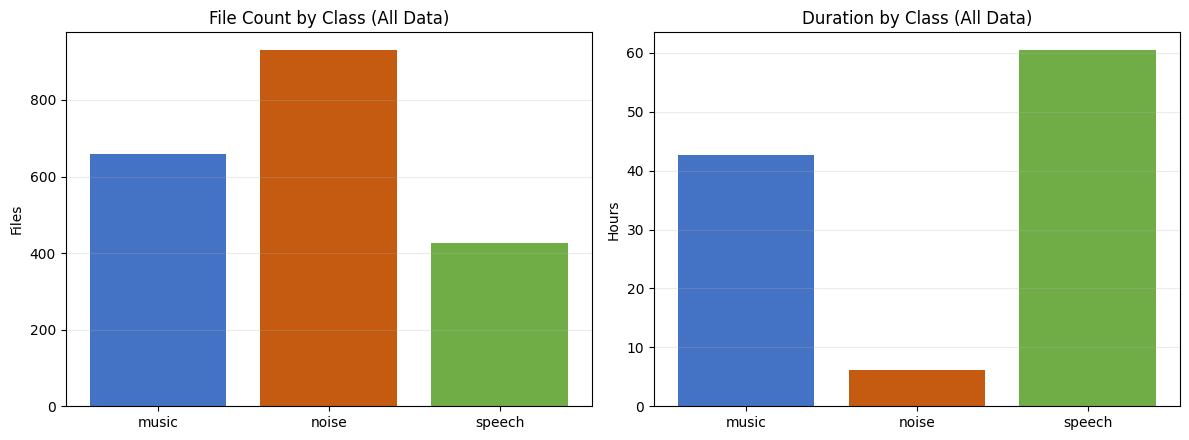

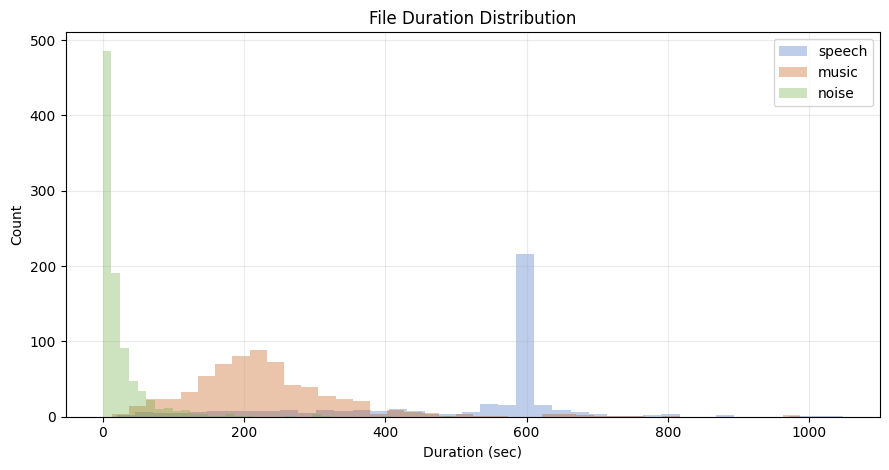

In [28]:
# Dataset composition and duration distributions
summary_plot_df = coverage_summary.copy().sort_values('label_name')

fig, axes = plt.subplots(1, 2, figsize=(12, 4.5))

axes[0].bar(summary_plot_df['label_name'], summary_plot_df['files'], color=['#4472c4', '#c55a11', '#70ad47'])
axes[0].set_title('File Count by Class (All Data)')
axes[0].set_ylabel('Files')
axes[0].grid(axis='y', alpha=0.25)

axes[1].bar(summary_plot_df['label_name'], summary_plot_df['total_hours'], color=['#4472c4', '#c55a11', '#70ad47'])
axes[1].set_title('Duration by Class (All Data)')
axes[1].set_ylabel('Hours')
axes[1].grid(axis='y', alpha=0.25)

plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(9, 4.8))
for cls, color in [('speech', '#4472c4'), ('music', '#c55a11'), ('noise', '#70ad47')]:
    d = index_df[index_df['label_name'] == cls]['duration_sec'].values
    if len(d) == 0:
        continue
    ax.hist(d, bins=40, alpha=0.35, label=cls, color=color)
ax.set_title('File Duration Distribution')
ax.set_xlabel('Duration (sec)')
ax.set_ylabel('Count')
ax.grid(alpha=0.25)
ax.legend()
plt.tight_layout()
plt.show()

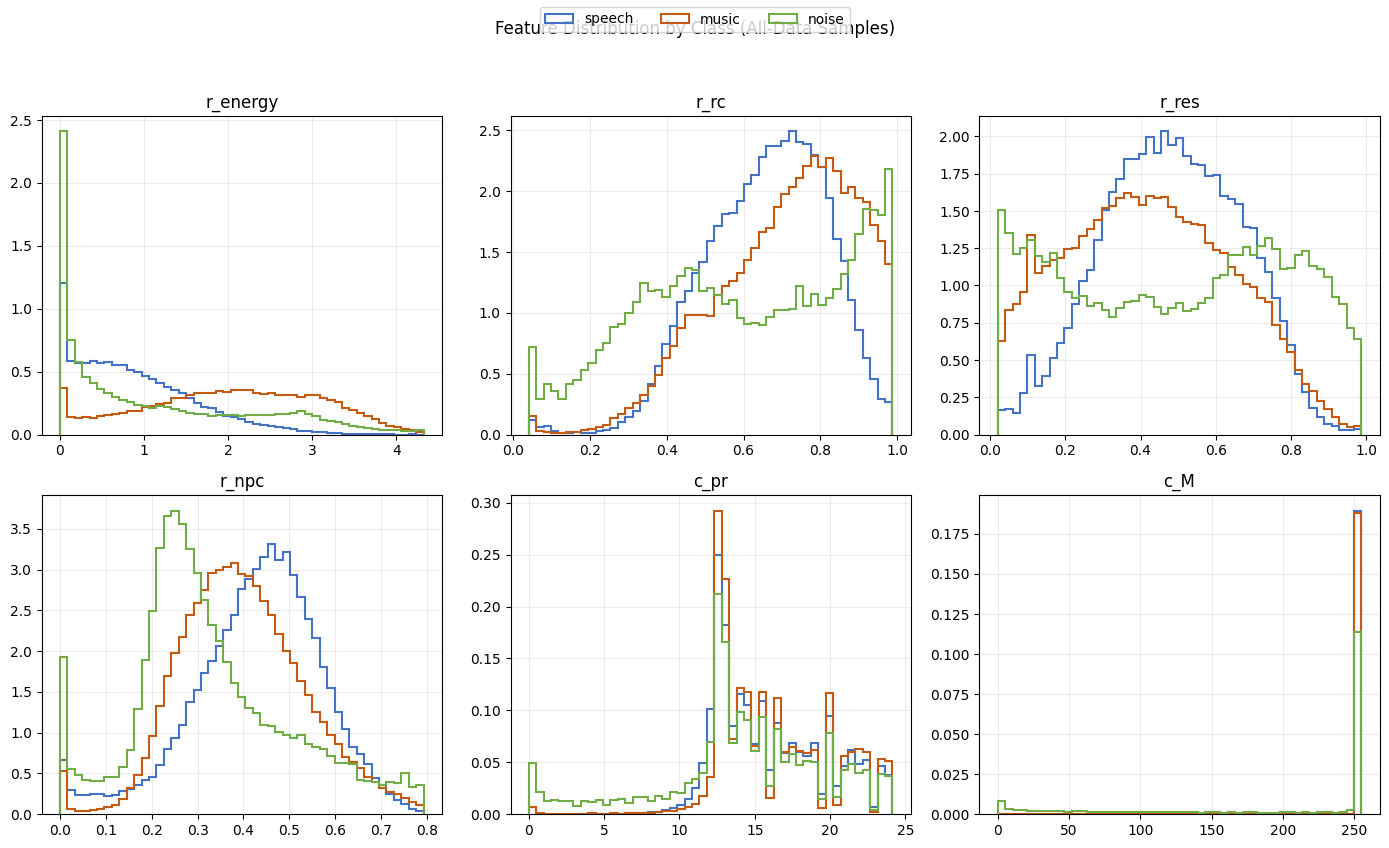

In [29]:
# Feature distributions from samples collected across all files
fig, axes = plt.subplots(2, 3, figsize=(14, 8.5))
axes = axes.ravel()

for j, fname in enumerate(FEATURE_NAMES):
    ax = axes[j]

    vals_all = []
    for cls in ['speech', 'music', 'noise']:
        x = feature_samples_all[cls]
        if x.shape[0] > 0:
            vals_all.append(x[:, j])
    if len(vals_all) == 0:
        continue

    concat_vals = np.concatenate(vals_all)
    lo, hi = np.percentile(concat_vals, [1, 99])
    bins = np.linspace(lo, hi, 50)

    for cls, color in [('speech', '#4472c4'), ('music', '#c55a11'), ('noise', '#70ad47')]:
        x = feature_samples_all[cls]
        if x.shape[0] == 0:
            continue
        ax.hist(x[:, j], bins=bins, density=True, histtype='step', linewidth=1.5, color=color, label=cls if j == 0 else None)

    ax.set_title(fname)
    ax.grid(alpha=0.22)

handles, labels = axes[0].get_legend_handles_labels()
if handles:
    fig.legend(handles, labels, loc='upper center', ncol=3)
fig.suptitle('Feature Distribution by Class (All-Data Samples)', y=0.98)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

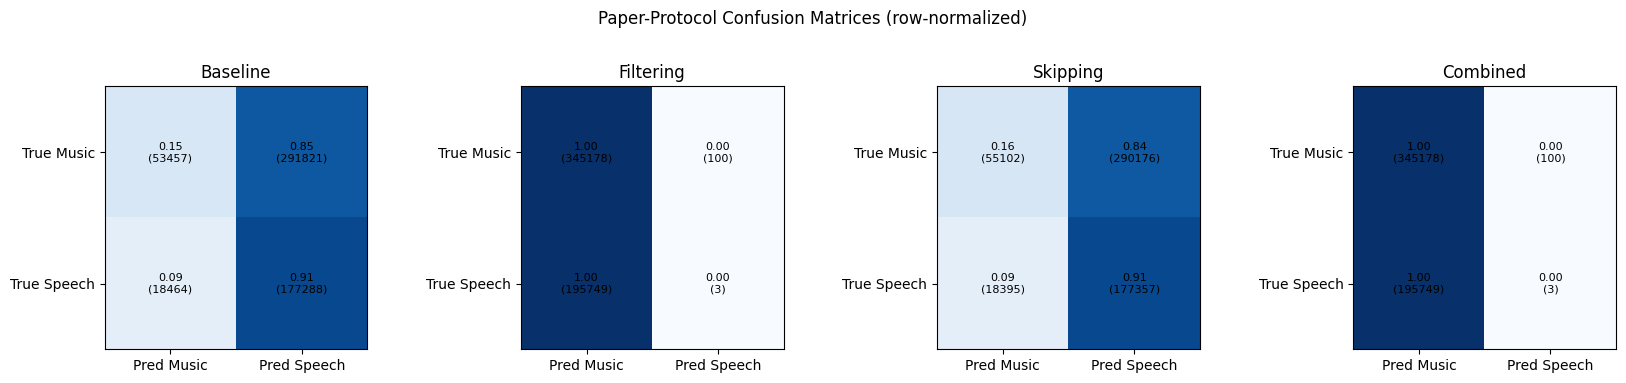

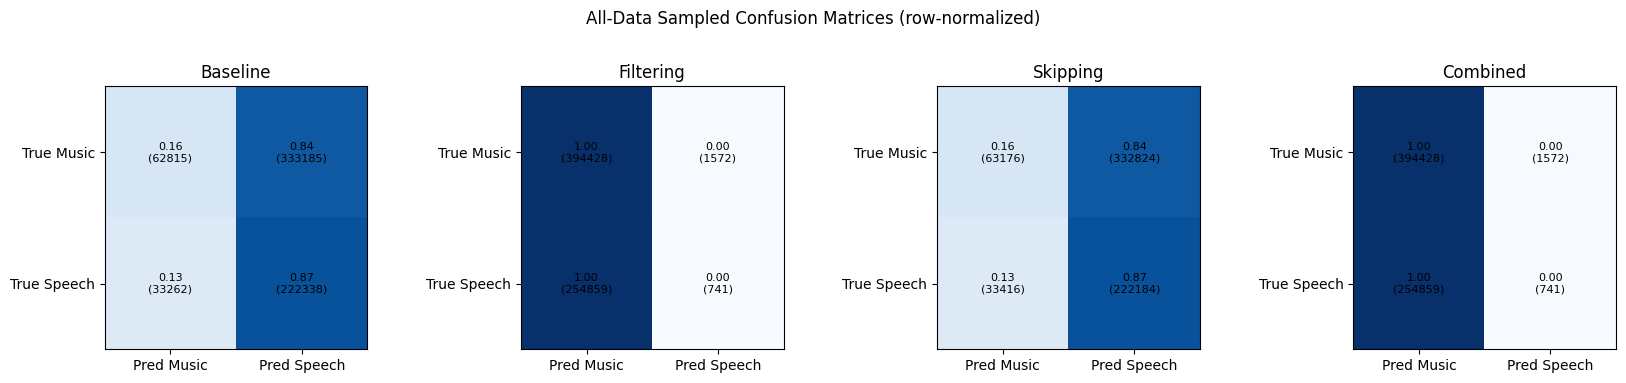

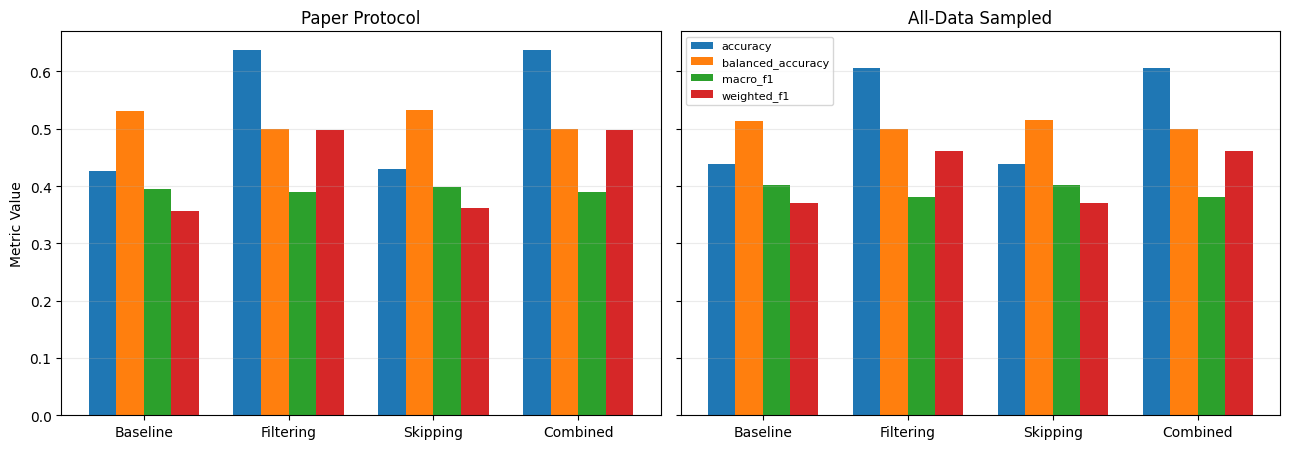

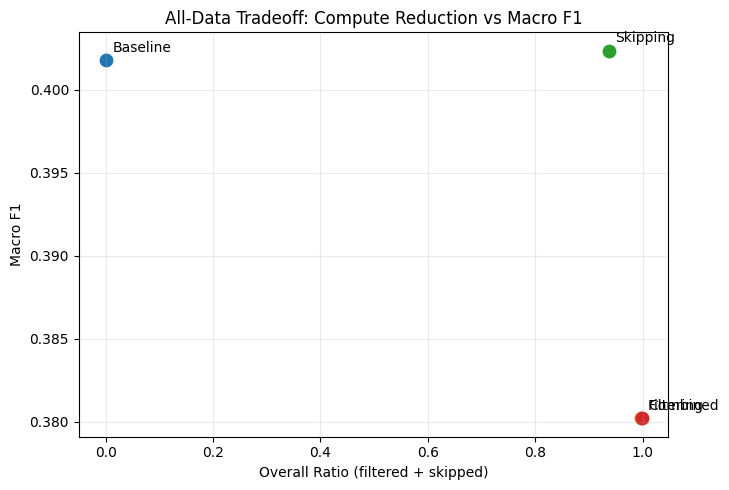

In [30]:
def confusion_matrix_from_row(row: pd.Series) -> np.ndarray:
    return np.array([[row['tn'], row['fp']], [row['fn'], row['tp']]], dtype=np.float64)


def plot_confusion_grid(df: pd.DataFrame, title: str):
    fig, axes = plt.subplots(1, len(METHOD_ORDER), figsize=(4.2 * len(METHOD_ORDER), 3.7))
    if len(METHOD_ORDER) == 1:
        axes = [axes]

    for i, method in enumerate(METHOD_ORDER):
        row = df[df['method'] == method].iloc[0]
        cm = confusion_matrix_from_row(row)
        row_sum = np.maximum(cm.sum(axis=1, keepdims=True), 1.0)
        cmn = cm / row_sum

        ax = axes[i]
        ax.imshow(cmn, cmap='Blues', vmin=0.0, vmax=1.0)
        ax.set_xticks([0, 1])
        ax.set_xticklabels(['Pred Music', 'Pred Speech'])
        ax.set_yticks([0, 1])
        ax.set_yticklabels(['True Music', 'True Speech'])
        ax.set_title(method)

        for r in range(2):
            for c in range(2):
                ax.text(c, r, f'{cmn[r, c]:.2f}\n({int(cm[r, c])})', ha='center', va='center', fontsize=8)

    fig.suptitle(title, y=1.02)
    plt.tight_layout()
    plt.show()


plot_confusion_grid(paper_overall_metrics_full, 'Paper-Protocol Confusion Matrices (row-normalized)')
plot_confusion_grid(full_data_method_metrics, 'All-Data Sampled Confusion Matrices (row-normalized)')

# Quality metric comparison
metric_cols = ['accuracy', 'balanced_accuracy', 'macro_f1', 'weighted_f1']

fig, axes = plt.subplots(1, 2, figsize=(13, 4.6), sharey=True)
for ax, df, ttl in [
    (axes[0], paper_overall_metrics_full, 'Paper Protocol'),
    (axes[1], full_data_method_metrics, 'All-Data Sampled'),
]:
    x = np.arange(len(METHOD_ORDER))
    width = 0.19
    for i, mc in enumerate(metric_cols):
        vals = [float(df[df['method'] == m][mc].iloc[0]) for m in METHOD_ORDER]
        ax.bar(x + (i - 1.5) * width, vals, width=width, label=mc)
    ax.set_xticks(x)
    ax.set_xticklabels(METHOD_ORDER)
    ax.set_title(ttl)
    ax.grid(axis='y', alpha=0.25)

axes[0].set_ylabel('Metric Value')
axes[1].legend(fontsize=8)
plt.tight_layout()
plt.show()

# Compute reduction vs macro-F1 tradeoff
fig, ax = plt.subplots(figsize=(7.4, 5.0))
for m in METHOD_ORDER:
    r = full_data_method_metrics[full_data_method_metrics['method'] == m].iloc[0]
    ax.scatter(r['overall_ratio'], r['macro_f1'], s=80)
    ax.annotate(m, (r['overall_ratio'], r['macro_f1']), xytext=(5, 6), textcoords='offset points')
ax.set_xlabel('Overall Ratio (filtered + skipped)')
ax.set_ylabel('Macro F1')
ax.set_title('All-Data Tradeoff: Compute Reduction vs Macro F1')
ax.grid(alpha=0.25)
plt.tight_layout()
plt.show()

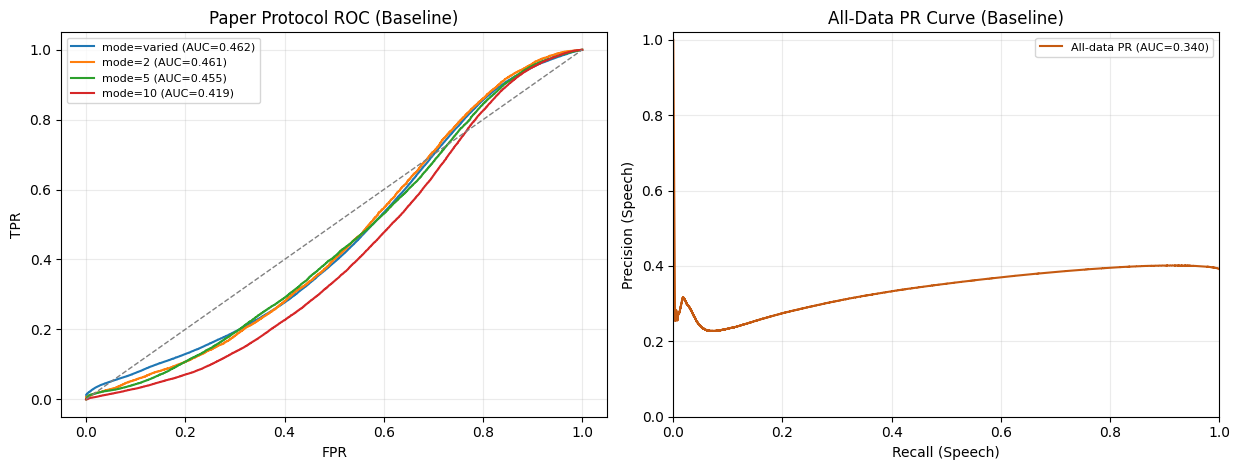

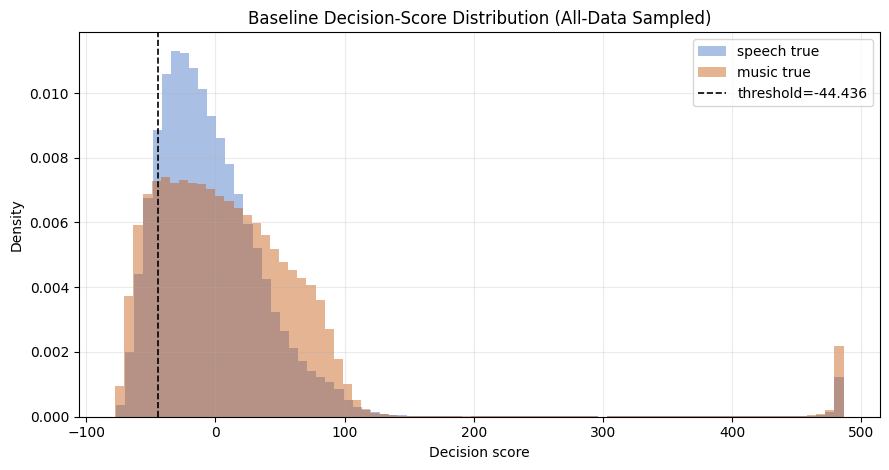

In [31]:
# ROC / PR curves where decision scores are available (Baseline)
fig, axes = plt.subplots(1, 2, figsize=(12.5, 4.8))

# Paper protocol baseline by mode
for mode in paper_test_sets.keys():
    curve = paper_mode_curves_by_method['Baseline'][mode]
    if curve is None:
        continue
    axes[0].plot(curve['fpr'], curve['tpr'], label=f"mode={mode} (AUC={curve['roc_auc']:.3f})")

axes[0].plot([0, 1], [0, 1], '--', color='gray', linewidth=1)
axes[0].set_title('Paper Protocol ROC (Baseline)')
axes[0].set_xlabel('FPR')
axes[0].set_ylabel('TPR')
axes[0].grid(alpha=0.25)
axes[0].legend(fontsize=8)

# All-data baseline PR
curve_full = full_data_curves_by_method['Baseline']
axes[1].plot(curve_full['recall'], curve_full['precision'], color='#c55a11', label=f"All-data PR (AUC={curve_full['pr_auc']:.3f})")
axes[1].set_title('All-Data PR Curve (Baseline)')
axes[1].set_xlabel('Recall (Speech)')
axes[1].set_ylabel('Precision (Speech)')
axes[1].set_ylim(0, 1.02)
axes[1].set_xlim(0, 1.0)
axes[1].grid(alpha=0.25)
axes[1].legend(fontsize=8)

plt.tight_layout()
plt.show()

# Score distributions for baseline on all-data sampled pass
scores_speech = np.concatenate(baseline_scores_by_class[1]) if len(baseline_scores_by_class[1]) else np.array([])
scores_music = np.concatenate(baseline_scores_by_class[-1]) if len(baseline_scores_by_class[-1]) else np.array([])

fig, ax = plt.subplots(figsize=(9, 4.8))
if len(scores_speech):
    ax.hist(scores_speech, bins=80, alpha=0.45, density=True, label='speech true', color='#4472c4')
if len(scores_music):
    ax.hist(scores_music, bins=80, alpha=0.45, density=True, label='music true', color='#c55a11')
ax.axvline(best_thr, color='black', linestyle='--', linewidth=1.2, label=f'threshold={best_thr:.3f}')
ax.set_title('Baseline Decision-Score Distribution (All-Data Sampled)')
ax.set_xlabel('Decision score')
ax.set_ylabel('Density')
ax.grid(alpha=0.25)
ax.legend()
plt.tight_layout()
plt.show()

In [32]:
# Consolidated tables for final review
print('Paper overall metrics (full):')
display(paper_overall_metrics_full[['method', 'accuracy', 'balanced_accuracy', 'macro_f1', 'weighted_f1', 'recall_speech', 'recall_music', 'mcc', 'kappa', 'roc_auc', 'pr_auc', 'overall_ratio', 'svm_call_ratio']])

print('All-data sampled overall metrics:')
display(full_data_method_metrics[['method', 'accuracy', 'balanced_accuracy', 'macro_f1', 'weighted_f1', 'recall_speech', 'recall_music', 'mcc', 'kappa', 'roc_auc', 'pr_auc', 'overall_ratio', 'svm_call_ratio']])

print('All-data per-label means:')
display(full_data_by_label.sort_values(['label_name', 'method']))

print('Noise behavior summary:')
display(noise_summary)

Paper overall metrics (full):


,method,accuracy,balanced_accuracy,macro_f1,weighted_f1,recall_speech,recall_music,mcc,kappa,roc_auc,pr_auc,overall_ratio,svm_call_ratio
0,Baseline,0.426492,0.530250,0.394787,0.356504,0.905677,0.154823,0.085630,0.046453,0.450228,0.322178,0.000000,1.000000
1,Filtering,0.638007,0.499863,0.389517,0.497160,0.000015,0.999710,-0.009554,-0.000350,NaN,NaN,0.874170,0.125830
2,Skipping,0.429660,0.532808,0.398971,0.361436,0.906029,0.159587,0.092026,0.050450,NaN,NaN,0.937476,0.062524
3,Combined,0.638007,0.499863,0.389517,0.497160,0.000015,0.999710,-0.009554,-0.000350,NaN,NaN,0.992088,0.007912


All-data sampled overall metrics:


,method,accuracy,balanced_accuracy,macro_f1,weighted_f1,recall_speech,recall_music,mcc,kappa,roc_auc,pr_auc,overall_ratio,svm_call_ratio
0,Baseline,0.437620,0.514245,0.401764,0.370207,0.869867,0.158624,0.039235,0.023585,0.436694,0.340135,0.000000,1.000000
1,Filtering,0.606459,0.499465,0.380212,0.460899,0.002899,0.996030,-0.008789,-0.001299,NaN,NaN,0.996450,0.003550
2,Skipping,0.437937,0.514400,0.402348,0.370923,0.869264,0.159535,0.039573,0.023848,NaN,NaN,0.936667,0.063333
3,Combined,0.606459,0.499465,0.380212,0.460899,0.002899,0.996030,-0.008789,-0.001299,NaN,NaN,0.998152,0.001848


All-data per-label means:


,method,label_name,accuracy,balanced_accuracy,macro_f1,weighted_f1,recall_speech,recall_music,mcc,overall_ratio,svm_call_ratio
0,Baseline,music,0.158624,0.158624,0.264052,NaN,NaN,0.158624,NaN,0.000000,1.000000
2,Combined,music,0.996030,0.996030,0.998004,NaN,NaN,0.996030,NaN,0.998162,0.001838
4,Filtering,music,0.996030,0.996030,0.998004,NaN,NaN,0.996030,NaN,0.996030,0.003970
6,Skipping,music,0.159535,0.159535,0.315790,NaN,NaN,0.159535,NaN,0.936667,0.063333
1,Baseline,speech,0.869867,0.869867,0.922189,NaN,0.869867,NaN,NaN,0.000000,1.000000
3,Combined,speech,0.002899,0.002899,0.005747,NaN,0.002899,NaN,NaN,0.998138,0.001862
5,Filtering,speech,0.002899,0.002899,0.005747,NaN,0.002899,NaN,NaN,0.997101,0.002899
7,Skipping,speech,0.869264,0.869264,0.920827,NaN,0.869264,NaN,NaN,0.936667,0.063333


Noise behavior summary:


,baseline_music_ratio,filtering_music_ratio,combined_music_ratio,filtering_ratio,combined_ratio,mean_score,std_score
mean,0.065796,0.88972,0.88972,0.88972,0.989257,215.704799,130.54581


## 16) Explanation / How to Read the Results
1. `paper_overall_metrics_full` is the main paper-protocol quality table with full metrics.
2. `paper_overall_norm_full` shows normalized quality relative to the baseline (`Baseline = 1.0`).
3. `full_data_method_metrics` reports method behavior on sampled inference across all speech/music files.
4. `full_data_by_label` breaks full-data behavior by true class, useful for speech-vs-music error asymmetry.
5. `noise_summary` shows how strongly non-speech/non-music content is forced toward music by filtering/combined logic.
6. Confusion, ROC/PR, and score-distribution plots provide threshold and tradeoff interpretability.

## 17) All-Dataset Protocol and Paper-Protocol Comparison
This section adds a second protocol that traverses all training files (speech/music) to train an SVM from scratch,
then compares it against the paper-style 20min+20min protocol on:
- paper-style synthetic test sets
- sampled full-data pass across all files
- compute-reduction vs quality tradeoffs

In [33]:
# ===== All-dataset protocol config =====
ALLDATA_PER_CLASS_TARGET = 5000  # dual RBF SVM tractability (10k total points)
ALLDATA_SAMPLE_SEED = SEED + 202

train_speech_allfiles = list(train_speech)
train_music_allfiles = list(train_music)

print('all-dataset protocol train speech files:', len(train_speech_allfiles))
print('all-dataset protocol train music files :', len(train_music_allfiles))

frame_count_map = dict(zip(index_df['cache_path'], index_df['n_frames']))


def streaming_mean_std_from_files(file_list: List[str], log_every: int = 120) -> Tuple[np.ndarray, np.ndarray, int]:
    sum_vec = np.zeros((6,), dtype=np.float64)
    sumsq_vec = np.zeros((6,), dtype=np.float64)
    count = 0

    for i, cp in enumerate(file_list, start=1):
        x = np.load(cp, mmap_mode='r')
        if x.shape[0] == 0:
            continue
        xf = np.asarray(x, dtype=np.float64)
        sum_vec += xf.sum(axis=0)
        sumsq_vec += (xf * xf).sum(axis=0)
        count += int(x.shape[0])

        if i % log_every == 0 or i == len(file_list):
            print(f'stats pass {i}/{len(file_list)} files, frames={count}')

    mean = sum_vec / max(count, 1)
    var = np.maximum(sumsq_vec / max(count, 1) - mean * mean, 1e-8)
    std = np.sqrt(var)
    return mean.astype(np.float32), std.astype(np.float32), int(count)


def sample_reservoir_all_files(file_list: List[str], per_class_target: int, seed: int) -> np.ndarray:
    """
    Ensures every training file contributes at least one frame, then distributes
    remaining quota proportionally to frame counts.
    """
    rng = np.random.default_rng(seed)

    valid_files = [cp for cp in file_list if int(frame_count_map.get(cp, 0)) > 0]
    n_files = len(valid_files)
    if n_files == 0:
        return np.zeros((0, 6), dtype=np.float32)

    target = max(int(per_class_target), n_files)

    weights = np.array([float(frame_count_map[cp]) for cp in valid_files], dtype=np.float64)
    probs = weights / np.sum(weights)

    counts = np.ones((n_files,), dtype=np.int64)
    remain = target - n_files
    if remain > 0:
        extra_idx = rng.choice(n_files, size=remain, replace=True, p=probs)
        counts += np.bincount(extra_idx, minlength=n_files)

    chunks = []
    for i, cp in enumerate(valid_files):
        x = np.load(cp)
        n = x.shape[0]
        k = int(counts[i])

        if k <= n:
            idx = rng.choice(n, size=k, replace=False)
        else:
            idx = rng.choice(n, size=k, replace=True)

        chunks.append(x[idx].astype(np.float32))

    X = np.vstack(chunks)
    perm = rng.permutation(X.shape[0])
    return X[perm]


def calibrate_threshold_balanced(scores: np.ndarray, y: np.ndarray) -> Tuple[float, float]:
    best_thr = 0.0
    best_ba = -1.0
    qs = np.quantile(scores, np.linspace(0.01, 0.99, 99))
    for thr in qs:
        pred = np.where(scores >= thr, 1, -1)
        rec_s = np.mean(pred[y == 1] == 1)
        rec_m = np.mean(pred[y == -1] == -1)
        ba = 0.5 * (rec_s + rec_m)
        if ba > best_ba:
            best_ba = float(ba)
            best_thr = float(thr)
    return best_thr, best_ba


# 1) Global normalization stats from all training files (speech+music)
feat_mean_all, feat_std_all, n_stats_all = streaming_mean_std_from_files(
    train_speech_allfiles + train_music_allfiles,
    log_every=180,
)
print('all-dataset stats frames:', n_stats_all)
print('all-dataset feature mean:', np.round(feat_mean_all, 4))
print('all-dataset feature std :', np.round(feat_std_all, 4))

# 2) Reservoir sampling with all-file coverage
X_speech_all = sample_reservoir_all_files(train_speech_allfiles, ALLDATA_PER_CLASS_TARGET, ALLDATA_SAMPLE_SEED)
X_music_all = sample_reservoir_all_files(train_music_allfiles, ALLDATA_PER_CLASS_TARGET, ALLDATA_SAMPLE_SEED + 1)

X_all_train_raw = np.vstack([X_speech_all, X_music_all]).astype(np.float32)
y_all_train = np.concatenate([
    np.ones((X_speech_all.shape[0],), dtype=np.int64),
    -np.ones((X_music_all.shape[0],), dtype=np.int64),
])

perm = np.random.default_rng(ALLDATA_SAMPLE_SEED + 2).permutation(len(y_all_train))
X_all_train_raw = X_all_train_raw[perm]
y_all_train = y_all_train[perm]

X_all_train = (X_all_train_raw - feat_mean_all) / feat_std_all

print('all-dataset train matrix:', X_all_train.shape)
print('all-dataset class counts:', {int(c): int(np.sum(y_all_train == c)) for c in np.unique(y_all_train)})

# 3) Train SVM (from scratch)
svm_all = TorchRBFSVM(**SVM_PARAMS)
t0 = time.perf_counter()
svm_all.fit(X_all_train, y_all_train)
train_all_sec = time.perf_counter() - t0
print(f'all-dataset train time: {train_all_sec:.2f}s')
print('all-dataset support vectors:', len(svm_all.alpha))
print('all-dataset bias b:', svm_all.b)

# 4) Threshold calibration for all-dataset protocol
scores_all_train = svm_all.decision_function(X_all_train)
best_thr_all, best_ba_all = calibrate_threshold_balanced(scores_all_train, y_all_train)
print('all-dataset chosen threshold:', best_thr_all)
print('all-dataset train balanced accuracy:', best_ba_all)

all-dataset protocol train speech files: 340
all-dataset protocol train music files : 528
stats pass 180/868 files, frames=4466568


stats pass 360/868 files, frames=8833607
stats pass 540/868 files, frames=10940437
stats pass 720/868 files, frames=13087458
stats pass 868/868 files, frames=14820091
all-dataset stats frames: 14820091
all-dataset feature mean: [  1.3595   0.6759   0.468    0.422   16.0243 253.3854]
all-dataset feature std : [ 1.0108  0.1667  0.1985  0.1365  3.7777 16.5185]


all-dataset train matrix: (10000, 6)
all-dataset class counts: {-1: 5000, 1: 5000}


all-dataset train time: 6.01s
all-dataset support vectors: 8364
all-dataset bias b: 541.3716484308243


all-dataset chosen threshold: -78.97374084472656
all-dataset train balanced accuracy: 0.5046


In [34]:
def build_paper_baseline_cache_for_model(svm_model: TorchRBFSVM, mean_vec: np.ndarray, std_vec: np.ndarray, thr: float):
    cache = {}
    timings = []

    for mode, files in paper_test_sets.items():
        for f in files:
            key = (mode, f['file_id'])
            Xn = (f['raw'] - mean_vec) / std_vec

            t0 = time.perf_counter()
            scores = svm_model.decision_function(Xn)
            elapsed = time.perf_counter() - t0

            pred = np.where(scores >= thr, 1, -1).astype(np.int64)
            cache[key] = {'scores': scores, 'pred': pred}
            timings.append((elapsed, len(pred)))

    ms_per_frame = 1000.0 * safe_div(sum(t for t, n in timings), sum(n for t, n in timings))
    return cache, ms_per_frame


def evaluate_paper_methods_from_cache(baseline_cache_local: Dict[Tuple[str, int], dict], baseline_ms_per_frame_local: float, protocol_name: str):
    rows_file = []
    rows_mode = []
    rows_overall = []

    method_params = {
        'Baseline': {},
        'Filtering': FILTERING_PAPER,
        'Skipping': SKIPPING_PAPER,
        'Combined': COMBINED_PAPER,
    }

    for method in METHOD_ORDER:
        mode_store = {
            mode: {
                'y': [], 'pred': [], 'scores': [],
                'filtered': 0, 'skipped': 0, 'svm_calls': 0, 'total': 0,
            }
            for mode in paper_test_sets.keys()
        }

        all_y = []
        all_pred = []
        all_scores = []
        total_filtered = 0
        total_skipped = 0
        total_svm_calls = 0
        total_frames = 0

        for mode, files in paper_test_sets.items():
            for f in files:
                key = (mode, f['file_id'])
                raw = f['raw']
                y_true = f['y_true']
                base_scores = baseline_cache_local[key]['scores']
                base_pred = baseline_cache_local[key]['pred']

                if method == 'Baseline':
                    y_pred = base_pred
                    info = {'filtered': 0, 'skipped': 0, 'svm_calls': len(y_pred)}
                    score_for_auc = base_scores
                elif method == 'Filtering':
                    y_pred, info = run_filtering(raw, base_pred, **FILTERING_PAPER)
                    score_for_auc = None
                elif method == 'Skipping':
                    y_pred, info = run_skipping(base_pred, **SKIPPING_PAPER)
                    score_for_auc = None
                elif method == 'Combined':
                    y_pred, info = run_combined(raw, base_pred, **COMBINED_PAPER)
                    score_for_auc = None
                else:
                    raise ValueError(method)

                met = binary_metrics_full(y_true, y_pred, scores=score_for_auc)
                total = len(y_true)

                rows_file.append({
                    'protocol': protocol_name,
                    'mode': mode,
                    'file_id': f['file_id'],
                    'method': method,
                    **met,
                    'filtered_ratio': info['filtered'] / max(total, 1),
                    'skipped_ratio': info['skipped'] / max(total, 1),
                    'overall_ratio': (info['filtered'] + info['skipped']) / max(total, 1),
                    'svm_call_ratio': info['svm_calls'] / max(total, 1),
                })

                m = (y_true != 0)
                mode_store[mode]['y'].append(y_true[m])
                mode_store[mode]['pred'].append(y_pred[m])
                if score_for_auc is not None:
                    mode_store[mode]['scores'].append(score_for_auc[m])

                mode_store[mode]['filtered'] += int(info['filtered'])
                mode_store[mode]['skipped'] += int(info['skipped'])
                mode_store[mode]['svm_calls'] += int(info['svm_calls'])
                mode_store[mode]['total'] += int(total)

                all_y.append(y_true[m])
                all_pred.append(y_pred[m])
                if score_for_auc is not None:
                    all_scores.append(score_for_auc[m])

                total_filtered += int(info['filtered'])
                total_skipped += int(info['skipped'])
                total_svm_calls += int(info['svm_calls'])
                total_frames += int(total)

        for mode in paper_test_sets.keys():
            yt = np.concatenate(mode_store[mode]['y'])
            yp = np.concatenate(mode_store[mode]['pred'])
            sc = np.concatenate(mode_store[mode]['scores']) if len(mode_store[mode]['scores']) else None

            met_mode = binary_metrics_full(yt, yp, scores=sc)
            rows_mode.append({
                'protocol': protocol_name,
                'mode': mode,
                'method': method,
                **met_mode,
                'filtered_ratio': mode_store[mode]['filtered'] / max(mode_store[mode]['total'], 1),
                'skipped_ratio': mode_store[mode]['skipped'] / max(mode_store[mode]['total'], 1),
                'overall_ratio': (mode_store[mode]['filtered'] + mode_store[mode]['skipped']) / max(mode_store[mode]['total'], 1),
                'svm_call_ratio': mode_store[mode]['svm_calls'] / max(mode_store[mode]['total'], 1),
            })

        yt_all = np.concatenate(all_y)
        yp_all = np.concatenate(all_pred)
        sc_all = np.concatenate(all_scores) if len(all_scores) else None
        met_all = binary_metrics_full(yt_all, yp_all, scores=sc_all)

        rows_overall.append({
            'protocol': protocol_name,
            'method': method,
            **met_all,
            'filtered_ratio': total_filtered / max(total_frames, 1),
            'skipped_ratio': total_skipped / max(total_frames, 1),
            'overall_ratio': (total_filtered + total_skipped) / max(total_frames, 1),
            'svm_call_ratio': total_svm_calls / max(total_frames, 1),
            'estimated_exec_ms_per_frame': baseline_ms_per_frame_local * (total_svm_calls / max(total_frames, 1)),
        })

    df_file = pd.DataFrame(rows_file)
    df_mode = pd.DataFrame(rows_mode)
    df_overall = pd.DataFrame(rows_overall)
    df_overall['method'] = pd.Categorical(df_overall['method'], categories=METHOD_ORDER, ordered=True)
    df_overall = df_overall.sort_values('method').reset_index(drop=True)

    # protocol-local normalization vs baseline
    base_row = df_overall[df_overall['method'] == 'Baseline'].iloc[0]
    norm_rows = []
    norm_cols = ['accuracy', 'balanced_accuracy', 'macro_f1', 'weighted_f1', 'recall_speech', 'recall_music']
    for _, r in df_overall.iterrows():
        row = {'protocol': protocol_name, 'method': r['method'], 'overall_ratio': r['overall_ratio'], 'svm_call_ratio': r['svm_call_ratio']}
        for c in norm_cols:
            row[f'{c}_norm'] = safe_div(r[c], base_row[c])
        norm_rows.append(row)

    df_norm = pd.DataFrame(norm_rows)
    df_norm['method'] = pd.Categorical(df_norm['method'], categories=METHOD_ORDER, ordered=True)
    df_norm = df_norm.sort_values('method').reset_index(drop=True)

    return df_file, df_mode, df_overall, df_norm


# Build baseline caches for both protocols
paper_cache_20m, paper_ms_20m = build_paper_baseline_cache_for_model(svm, feat_mean, feat_std, best_thr)
paper_cache_alltrain, paper_ms_alltrain = build_paper_baseline_cache_for_model(svm_all, feat_mean_all, feat_std_all, best_thr_all)

paper_file_20m, paper_mode_20m, paper_overall_20m, paper_norm_20m = evaluate_paper_methods_from_cache(paper_cache_20m, paper_ms_20m, 'Paper20m')
paper_file_all, paper_mode_all, paper_overall_all, paper_norm_all = evaluate_paper_methods_from_cache(paper_cache_alltrain, paper_ms_alltrain, 'AllDatasetTrain')

paper_protocol_compare_file = pd.concat([paper_file_20m, paper_file_all], ignore_index=True)
paper_protocol_compare_mode = pd.concat([paper_mode_20m, paper_mode_all], ignore_index=True)
paper_protocol_compare_overall = pd.concat([paper_overall_20m, paper_overall_all], ignore_index=True)
paper_protocol_compare_norm = pd.concat([paper_norm_20m, paper_norm_all], ignore_index=True)

print('Paper-style protocol comparison built.')
print('rows overall:', len(paper_protocol_compare_overall), 'rows mode:', len(paper_protocol_compare_mode))
display(paper_protocol_compare_overall[['protocol', 'method', 'accuracy', 'balanced_accuracy', 'macro_f1', 'weighted_f1', 'recall_speech', 'recall_music', 'overall_ratio', 'svm_call_ratio', 'estimated_exec_ms_per_frame']])

Paper-style protocol comparison built.
rows overall: 8 rows mode: 32


,protocol,method,accuracy,balanced_accuracy,macro_f1,weighted_f1,recall_speech,recall_music,overall_ratio,svm_call_ratio,estimated_exec_ms_per_frame
0,Paper20m,Baseline,0.426492,0.530250,0.394787,0.356504,0.905677,0.154823,0.000000,1.000000,0.046977
1,Paper20m,Filtering,0.638007,0.499863,0.389517,0.497160,0.000015,0.999710,0.874170,0.125830,0.005911
2,Paper20m,Skipping,0.429660,0.532808,0.398971,0.361436,0.906029,0.159587,0.937476,0.062524,0.002937
3,Paper20m,Combined,0.638007,0.499863,0.389517,0.497160,0.000015,0.999710,0.992088,0.007912,0.000372
4,AllDatasetTrain,Baseline,0.365564,0.502111,0.273904,0.202605,0.996179,0.008043,0.000000,1.000000,0.036149
5,AllDatasetTrain,Filtering,0.638007,0.499863,0.389517,0.497160,0.000015,0.999710,0.874170,0.125830,0.004549
6,AllDatasetTrain,Skipping,0.366551,0.503002,0.275382,0.204346,0.996725,0.009279,0.937476,0.062524,0.002260
7,AllDatasetTrain,Combined,0.638007,0.499863,0.389517,0.497160,0.000015,0.999710,0.992088,0.007912,0.000286


In [35]:
def evaluate_full_data_sampled_protocol(
    svm_model: TorchRBFSVM,
    mean_vec: np.ndarray,
    std_vec: np.ndarray,
    thr: float,
    protocol_name: str,
    max_frames_per_file: int,
):
    sm_df = speech_music_df if 'speech_music_df' in globals() else index_df[index_df['label'].isin([1, -1])].copy().reset_index(drop=True)
    nz_df = noise_df if 'noise_df' in globals() else index_df[index_df['label'] == 0].copy().reset_index(drop=True)

    method_store = {
        m: {
            'y': [], 'pred': [], 'scores': [],
            'filtered': 0, 'skipped': 0, 'svm_calls': 0, 'total': 0,
        }
        for m in METHOD_ORDER
    }

    file_rows = []
    by_label_rows = []
    baseline_scores_by_class_local = {1: [], -1: []}

    baseline_sec = 0.0
    baseline_frames = 0

    for i, row in enumerate(sm_df.itertuples(index=False), start=1):
        raw_all = np.load(row.cache_path)
        raw = even_subsample_frames(raw_all, max_frames_per_file)

        y_true = np.full(raw.shape[0], int(row.label), dtype=np.int64)
        Xn = (raw - mean_vec) / std_vec

        t0 = time.perf_counter()
        scores = svm_model.decision_function(Xn)
        baseline_sec += (time.perf_counter() - t0)
        baseline_frames += int(len(scores))

        base_pred = np.where(scores >= thr, 1, -1).astype(np.int64)
        baseline_scores_by_class_local[int(row.label)].append(scores)

        method_outputs = {
            'Baseline': (base_pred, {'filtered': 0, 'skipped': 0, 'svm_calls': len(base_pred)}, scores),
            'Filtering': (*run_filtering(raw, base_pred, **FILTERING_PAPER), None),
            'Skipping': (*run_skipping(base_pred, **SKIPPING_PAPER), None),
            'Combined': (*run_combined(raw, base_pred, **COMBINED_PAPER), None),
        }

        for method in METHOD_ORDER:
            y_pred, info, score_for_auc = method_outputs[method]
            met = binary_metrics_full(y_true, y_pred, scores=score_for_auc)
            total = len(y_true)

            file_rows.append({
                'protocol': protocol_name,
                'method': method,
                'file_path': row.path,
                'label_name': row.label_name,
                'orig_frames': int(raw_all.shape[0]),
                'eval_frames': int(total),
                'coverage_ratio': safe_div(total, max(raw_all.shape[0], 1)),
                **met,
                'filtered_ratio': info['filtered'] / max(total, 1),
                'skipped_ratio': info['skipped'] / max(total, 1),
                'overall_ratio': (info['filtered'] + info['skipped']) / max(total, 1),
                'svm_call_ratio': info['svm_calls'] / max(total, 1),
            })

            method_store[method]['y'].append(y_true)
            method_store[method]['pred'].append(y_pred)
            if score_for_auc is not None:
                method_store[method]['scores'].append(score_for_auc)

            method_store[method]['filtered'] += int(info['filtered'])
            method_store[method]['skipped'] += int(info['skipped'])
            method_store[method]['svm_calls'] += int(info['svm_calls'])
            method_store[method]['total'] += int(total)

        if i % 180 == 0 or i == len(sm_df):
            print(f'[{protocol_name}] speech/music processed {i}/{len(sm_df)}')

    method_rows = []
    for method in METHOD_ORDER:
        yt = np.concatenate(method_store[method]['y'])
        yp = np.concatenate(method_store[method]['pred'])
        sc = np.concatenate(method_store[method]['scores']) if len(method_store[method]['scores']) else None
        met = binary_metrics_full(yt, yp, scores=sc)

        total = max(method_store[method]['total'], 1)
        method_rows.append({
            'protocol': protocol_name,
            'method': method,
            **met,
            'filtered_ratio': method_store[method]['filtered'] / total,
            'skipped_ratio': method_store[method]['skipped'] / total,
            'overall_ratio': (method_store[method]['filtered'] + method_store[method]['skipped']) / total,
            'svm_call_ratio': method_store[method]['svm_calls'] / total,
        })

    file_df = pd.DataFrame(file_rows)
    method_df = pd.DataFrame(method_rows)
    method_df['method'] = pd.Categorical(method_df['method'], categories=METHOD_ORDER, ordered=True)
    method_df = method_df.sort_values('method').reset_index(drop=True)

    by_label_df = (
        file_df
        .groupby(['protocol', 'method', 'label_name'], as_index=False)[['accuracy', 'balanced_accuracy', 'macro_f1', 'weighted_f1', 'recall_speech', 'recall_music', 'mcc', 'overall_ratio', 'svm_call_ratio']]
        .mean()
    )

    # Noise behavior
    noise_rows_local = []
    for i, row in enumerate(nz_df.itertuples(index=False), start=1):
        raw_all = np.load(row.cache_path)
        raw = even_subsample_frames(raw_all, max_frames_per_file)

        Xn = (raw - mean_vec) / std_vec
        scores = svm_model.decision_function(Xn)
        base_pred = np.where(scores >= thr, 1, -1).astype(np.int64)

        filt_pred, filt_info = run_filtering(raw, base_pred, **FILTERING_PAPER)
        comb_pred, comb_info = run_combined(raw, base_pred, **COMBINED_PAPER)

        noise_rows_local.append({
            'protocol': protocol_name,
            'baseline_music_ratio': float(np.mean(base_pred == -1)),
            'filtering_music_ratio': float(np.mean(filt_pred == -1)),
            'combined_music_ratio': float(np.mean(comb_pred == -1)),
            'filtering_ratio': safe_div(filt_info['filtered'], max(len(raw), 1)),
            'combined_ratio': safe_div(comb_info['filtered'] + comb_info['skipped'], max(len(raw), 1)),
            'mean_score': float(np.mean(scores)),
            'std_score': float(np.std(scores)),
        })

        if i % 250 == 0 or i == len(nz_df):
            print(f'[{protocol_name}] noise processed {i}/{len(nz_df)}')

    noise_df_local = pd.DataFrame(noise_rows_local)
    noise_summary_local = noise_df_local[[
        'baseline_music_ratio', 'filtering_music_ratio', 'combined_music_ratio',
        'filtering_ratio', 'combined_ratio', 'mean_score', 'std_score'
    ]].mean().to_frame('mean').T
    noise_summary_local.insert(0, 'protocol', protocol_name)

    baseline_ms = 1000.0 * safe_div(baseline_sec, baseline_frames)
    method_df['estimated_exec_ms_per_frame'] = baseline_ms * method_df['svm_call_ratio']

    return file_df, method_df, by_label_df, noise_summary_local, baseline_scores_by_class_local, baseline_ms


# Reuse previously computed paper-protocol full-data outputs as baseline for comparison
paper_full_method = full_data_method_metrics.copy()
paper_full_method.insert(0, 'protocol', 'Paper20m')
if 'estimated_exec_ms_per_frame' not in paper_full_method.columns:
    paper_full_method['estimated_exec_ms_per_frame'] = baseline_ms_per_frame_full_data * paper_full_method['svm_call_ratio']

paper_full_by_label = full_data_by_label.copy()
paper_full_by_label.insert(0, 'protocol', 'Paper20m')

paper_noise_summary_cmp = noise_summary.copy().copy()
paper_noise_summary_cmp.insert(0, 'protocol', 'Paper20m')

# Evaluate full-data sampled pass with all-dataset trained model
full_file_all, full_method_all, full_by_label_all, noise_summary_all, baseline_scores_by_class_all, baseline_ms_all = evaluate_full_data_sampled_protocol(
    svm_model=svm_all,
    mean_vec=feat_mean_all,
    std_vec=feat_std_all,
    thr=best_thr_all,
    protocol_name='AllDatasetTrain',
    max_frames_per_file=FULL_DATA_MAX_FRAMES_PER_FILE,
)

full_protocol_compare_overall = pd.concat([paper_full_method, full_method_all], ignore_index=True)
full_protocol_compare_by_label = pd.concat([paper_full_by_label, full_by_label_all], ignore_index=True)
full_protocol_compare_noise = pd.concat([paper_noise_summary_cmp, noise_summary_all], ignore_index=True)

print('Full-data sampled comparison built.')
display(full_protocol_compare_overall[['protocol', 'method', 'accuracy', 'balanced_accuracy', 'macro_f1', 'weighted_f1', 'recall_speech', 'recall_music', 'overall_ratio', 'svm_call_ratio', 'estimated_exec_ms_per_frame']])

[AllDatasetTrain] speech/music processed 180/1086


[AllDatasetTrain] speech/music processed 360/1086


/tmp/ipykernel_146415/1398865850.py:118: RuntimeWarning: Mean of empty slice
  macro_f1 = np.nanmean([f1_speech, f1_music])


[AllDatasetTrain] speech/music processed 540/1086


[AllDatasetTrain] speech/music processed 720/1086


[AllDatasetTrain] speech/music processed 900/1086


[AllDatasetTrain] speech/music processed 1080/1086
[AllDatasetTrain] speech/music processed 1086/1086


[AllDatasetTrain] noise processed 250/930


[AllDatasetTrain] noise processed 500/930


[AllDatasetTrain] noise processed 750/930


[AllDatasetTrain] noise processed 930/930
Full-data sampled comparison built.


,protocol,method,accuracy,balanced_accuracy,macro_f1,weighted_f1,recall_speech,recall_music,overall_ratio,svm_call_ratio,estimated_exec_ms_per_frame
0,Paper20m,Baseline,0.437620,0.514245,0.401764,0.370207,0.869867,0.158624,0.000000,1.000000,0.025657
1,Paper20m,Filtering,0.606459,0.499465,0.380212,0.460899,0.002899,0.996030,0.996450,0.003550,0.000091
2,Paper20m,Skipping,0.437937,0.514400,0.402348,0.370923,0.869264,0.159535,0.936667,0.063333,0.001625
3,Paper20m,Combined,0.606459,0.499465,0.380212,0.460899,0.002899,0.996030,0.998152,0.001848,0.000047
4,AllDatasetTrain,Baseline,0.396352,0.502165,0.292657,0.234302,0.993247,0.011083,0.000000,1.000000,0.047396
5,AllDatasetTrain,Filtering,0.606459,0.499465,0.380212,0.460899,0.002899,0.996030,0.996450,0.003550,0.000168
6,AllDatasetTrain,Skipping,0.396378,0.502296,0.292396,0.233950,0.993865,0.010727,0.936667,0.063333,0.003002
7,AllDatasetTrain,Combined,0.606459,0.499465,0.380212,0.460899,0.002899,0.996030,0.998152,0.001848,0.000088


## 18) Visual Comparison: Paper-Style Protocol vs All-Dataset Protocol

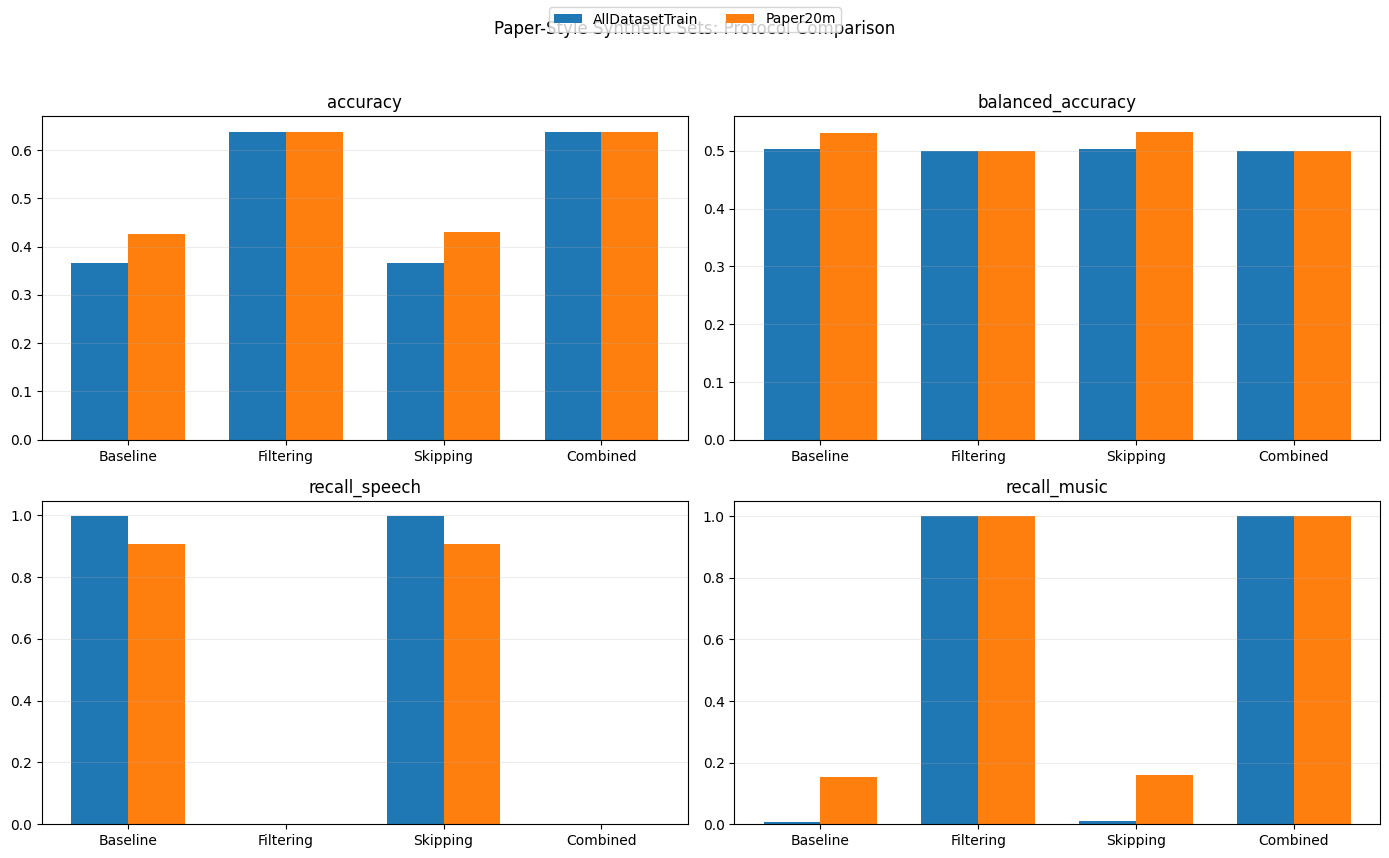

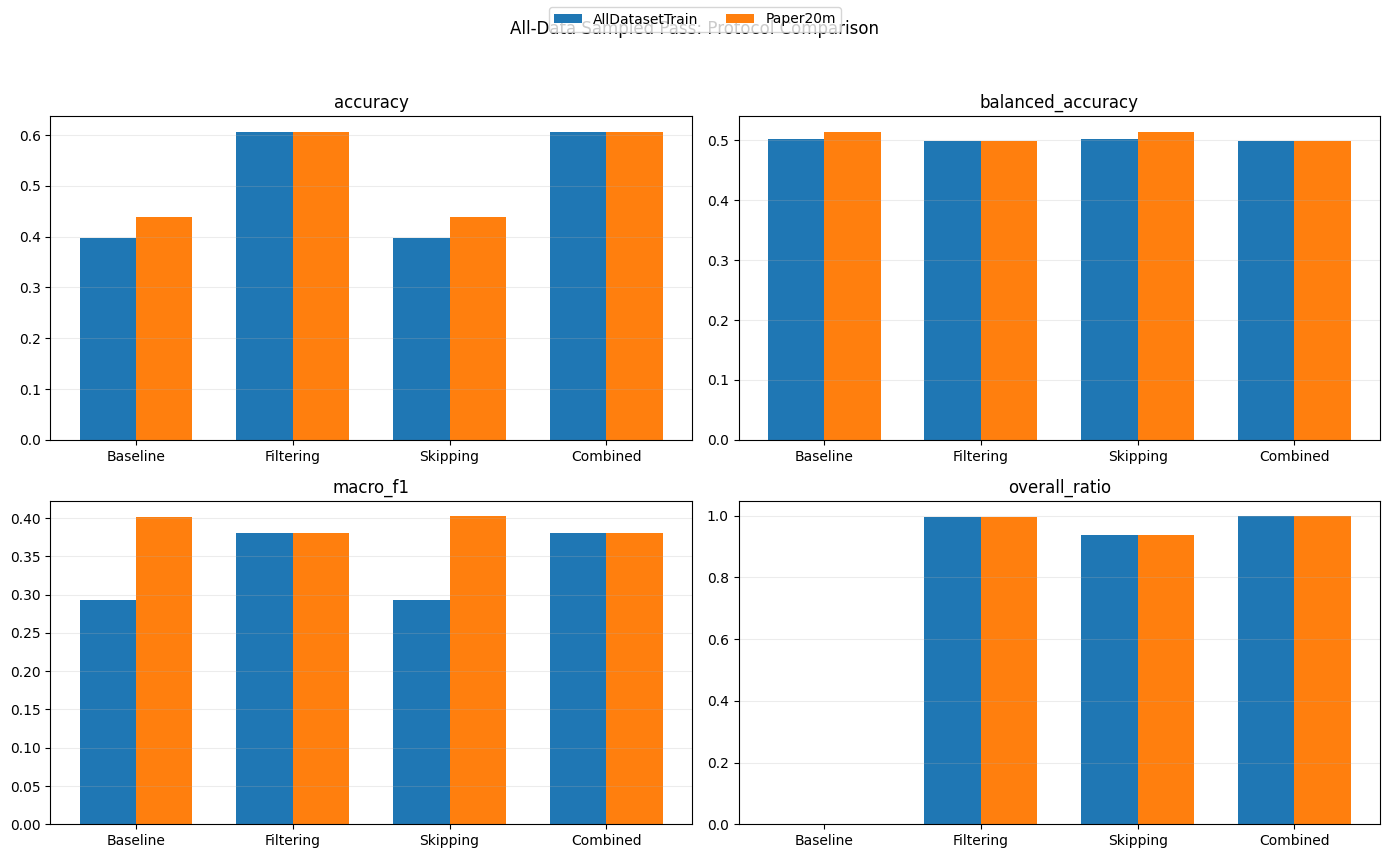

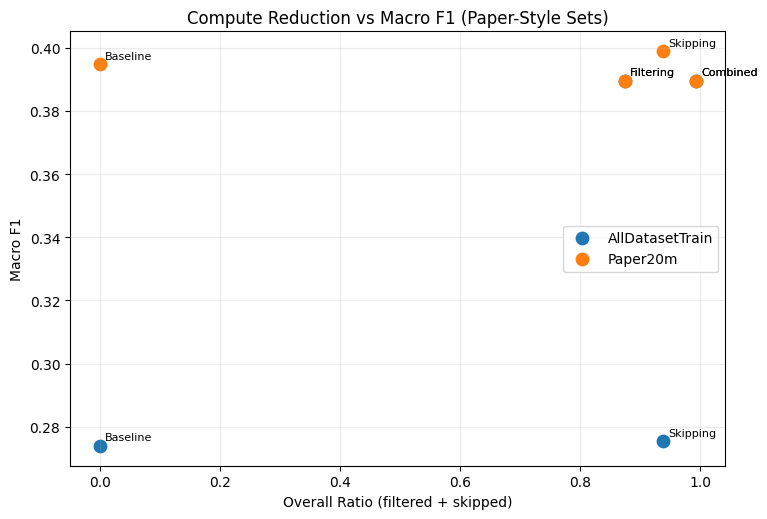

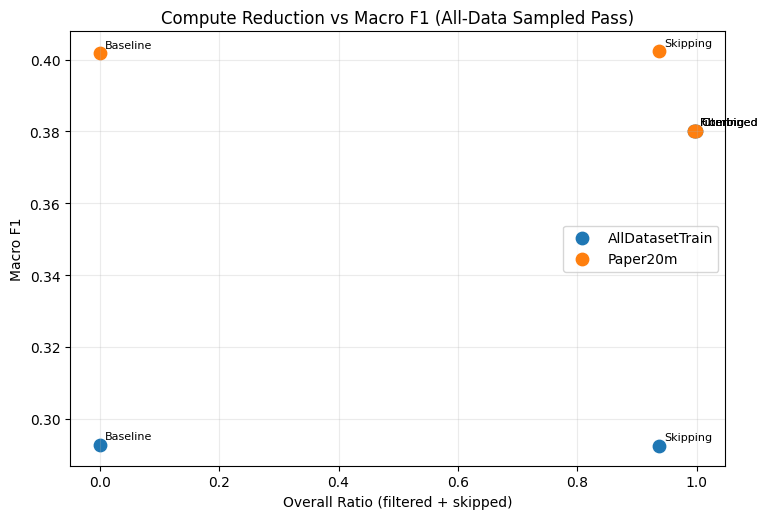

In [36]:
def plot_protocol_method_bars(df: pd.DataFrame, title: str, metric_list: List[str]):
    protocols = sorted(df['protocol'].unique())
    x = np.arange(len(METHOD_ORDER))
    width = 0.36 if len(protocols) == 2 else max(0.18, 0.8 / max(len(protocols), 1))

    fig, axes = plt.subplots(2, 2, figsize=(14, 8.6))
    axes = axes.ravel()

    for ax, metric in zip(axes, metric_list):
        for j, p in enumerate(protocols):
            d = df[df['protocol'] == p].copy()
            d['method'] = pd.Categorical(d['method'], categories=METHOD_ORDER, ordered=True)
            d = d.sort_values('method')
            vals = d[metric].values
            offset = (j - (len(protocols) - 1) / 2.0) * width
            ax.bar(x + offset, vals, width=width, label=p)

        ax.set_xticks(x)
        ax.set_xticklabels(METHOD_ORDER)
        ax.set_title(metric)
        ax.grid(axis='y', alpha=0.24)

    handles, labels = axes[0].get_legend_handles_labels()
    if handles:
        fig.legend(handles, labels, loc='upper center', ncol=len(protocols))

    fig.suptitle(title, y=0.98)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


plot_protocol_method_bars(
    paper_protocol_compare_overall,
    'Paper-Style Synthetic Sets: Protocol Comparison',
    ['accuracy', 'balanced_accuracy', 'recall_speech', 'recall_music'],
)

plot_protocol_method_bars(
    full_protocol_compare_overall,
    'All-Data Sampled Pass: Protocol Comparison',
    ['accuracy', 'balanced_accuracy', 'macro_f1', 'overall_ratio'],
)

# Compute reduction vs macro-F1, colored by protocol
for df, ttl in [
    (paper_protocol_compare_overall, 'Paper-Style Sets'),
    (full_protocol_compare_overall, 'All-Data Sampled Pass'),
]:
    fig, ax = plt.subplots(figsize=(7.8, 5.3))
    for protocol in sorted(df['protocol'].unique()):
        d = df[df['protocol'] == protocol]
        ax.scatter(d['overall_ratio'], d['macro_f1'], s=80, label=protocol)
        for _, r in d.iterrows():
            ax.annotate(f"{r['method']}", (r['overall_ratio'], r['macro_f1']), xytext=(4, 4), textcoords='offset points', fontsize=8)

    ax.set_xlabel('Overall Ratio (filtered + skipped)')
    ax.set_ylabel('Macro F1')
    ax.set_title(f'Compute Reduction vs Macro F1 ({ttl})')
    ax.grid(alpha=0.25)
    ax.legend()
    plt.tight_layout()
    plt.show()

In [37]:
# Protocol-focused summary tables
print('Paper-style protocol comparison (overall):')
display(paper_protocol_compare_overall[['protocol', 'method', 'accuracy', 'balanced_accuracy', 'macro_f1', 'weighted_f1', 'recall_speech', 'recall_music', 'overall_ratio', 'estimated_exec_ms_per_frame']])

print('Paper-style normalized-vs-baseline comparison (within protocol):')
display(paper_protocol_compare_norm[['protocol', 'method', 'accuracy_norm', 'balanced_accuracy_norm', 'macro_f1_norm', 'recall_speech_norm', 'recall_music_norm', 'overall_ratio', 'svm_call_ratio']])

print('All-data sampled protocol comparison (overall):')
display(full_protocol_compare_overall[['protocol', 'method', 'accuracy', 'balanced_accuracy', 'macro_f1', 'weighted_f1', 'recall_speech', 'recall_music', 'overall_ratio', 'estimated_exec_ms_per_frame']])

print('All-data per-label means (protocol comparison):')
display(full_protocol_compare_by_label.sort_values(['label_name', 'protocol', 'method']))

print('Noise behavior (protocol comparison):')
display(full_protocol_compare_noise)

Paper-style protocol comparison (overall):


,protocol,method,accuracy,balanced_accuracy,macro_f1,weighted_f1,recall_speech,recall_music,overall_ratio,estimated_exec_ms_per_frame
0,Paper20m,Baseline,0.426492,0.530250,0.394787,0.356504,0.905677,0.154823,0.000000,0.046977
1,Paper20m,Filtering,0.638007,0.499863,0.389517,0.497160,0.000015,0.999710,0.874170,0.005911
2,Paper20m,Skipping,0.429660,0.532808,0.398971,0.361436,0.906029,0.159587,0.937476,0.002937
3,Paper20m,Combined,0.638007,0.499863,0.389517,0.497160,0.000015,0.999710,0.992088,0.000372
4,AllDatasetTrain,Baseline,0.365564,0.502111,0.273904,0.202605,0.996179,0.008043,0.000000,0.036149
5,AllDatasetTrain,Filtering,0.638007,0.499863,0.389517,0.497160,0.000015,0.999710,0.874170,0.004549
6,AllDatasetTrain,Skipping,0.366551,0.503002,0.275382,0.204346,0.996725,0.009279,0.937476,0.002260
7,AllDatasetTrain,Combined,0.638007,0.499863,0.389517,0.497160,0.000015,0.999710,0.992088,0.000286


Paper-style normalized-vs-baseline comparison (within protocol):


,protocol,method,accuracy_norm,balanced_accuracy_norm,macro_f1_norm,recall_speech_norm,recall_music_norm,overall_ratio,svm_call_ratio
0,Paper20m,Baseline,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000
1,Paper20m,Filtering,1.495941,0.942693,0.986649,0.000017,6.457115,0.874170,0.125830
2,Paper20m,Skipping,1.007428,1.004825,1.010597,1.000389,1.030772,0.937476,0.062524
3,Paper20m,Combined,1.495941,0.942693,0.986649,0.000017,6.457115,0.992088,0.007912
4,AllDatasetTrain,Baseline,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000
5,AllDatasetTrain,Filtering,1.745269,0.995523,1.422093,0.000015,124.298884,0.874170,0.125830
6,AllDatasetTrain,Skipping,1.002700,1.001776,1.005396,1.000549,1.153763,0.937476,0.062524
7,AllDatasetTrain,Combined,1.745269,0.995523,1.422093,0.000015,124.298884,0.992088,0.007912


All-data sampled protocol comparison (overall):


,protocol,method,accuracy,balanced_accuracy,macro_f1,weighted_f1,recall_speech,recall_music,overall_ratio,estimated_exec_ms_per_frame
0,Paper20m,Baseline,0.437620,0.514245,0.401764,0.370207,0.869867,0.158624,0.000000,0.025657
1,Paper20m,Filtering,0.606459,0.499465,0.380212,0.460899,0.002899,0.996030,0.996450,0.000091
2,Paper20m,Skipping,0.437937,0.514400,0.402348,0.370923,0.869264,0.159535,0.936667,0.001625
3,Paper20m,Combined,0.606459,0.499465,0.380212,0.460899,0.002899,0.996030,0.998152,0.000047
4,AllDatasetTrain,Baseline,0.396352,0.502165,0.292657,0.234302,0.993247,0.011083,0.000000,0.047396
5,AllDatasetTrain,Filtering,0.606459,0.499465,0.380212,0.460899,0.002899,0.996030,0.996450,0.000168
6,AllDatasetTrain,Skipping,0.396378,0.502296,0.292396,0.233950,0.993865,0.010727,0.936667,0.003002
7,AllDatasetTrain,Combined,0.606459,0.499465,0.380212,0.460899,0.002899,0.996030,0.998152,0.000088


All-data per-label means (protocol comparison):


,protocol,method,label_name,accuracy,balanced_accuracy,macro_f1,weighted_f1,recall_speech,recall_music,mcc,overall_ratio,svm_call_ratio
8,AllDatasetTrain,Baseline,music,0.011083,0.011083,0.046642,NaN,NaN,0.011083,NaN,0.000000,1.000000
10,AllDatasetTrain,Combined,music,0.996030,0.996030,0.998004,NaN,NaN,0.996030,NaN,0.998162,0.001838
12,AllDatasetTrain,Filtering,music,0.996030,0.996030,0.998004,NaN,NaN,0.996030,NaN,0.996030,0.003970
14,AllDatasetTrain,Skipping,music,0.010727,0.010727,0.109855,NaN,NaN,0.010727,NaN,0.936667,0.063333
0,Paper20m,Baseline,music,0.158624,0.158624,0.264052,NaN,NaN,0.158624,NaN,0.000000,1.000000
2,Paper20m,Combined,music,0.996030,0.996030,0.998004,NaN,NaN,0.996030,NaN,0.998162,0.001838
4,Paper20m,Filtering,music,0.996030,0.996030,0.998004,NaN,NaN,0.996030,NaN,0.996030,0.003970
6,Paper20m,Skipping,music,0.159535,0.159535,0.315790,NaN,NaN,0.159535,NaN,0.936667,0.063333
9,AllDatasetTrain,Baseline,speech,0.993247,0.993247,0.996561,NaN,0.993247,NaN,NaN,0.000000,1.000000
11,AllDatasetTrain,Combined,speech,0.002899,0.002899,0.005747,NaN,0.002899,NaN,NaN,0.998138,0.001862


Noise behavior (protocol comparison):


,protocol,baseline_music_ratio,filtering_music_ratio,combined_music_ratio,filtering_ratio,combined_ratio,mean_score,std_score
0,Paper20m,0.065796,0.88972,0.88972,0.88972,0.989257,215.704799,130.545810
1,AllDatasetTrain,0.003762,0.88972,0.88972,0.88972,0.989257,163.766051,109.263841


In [38]:
# Contextual analysis against paper constraint style (<=2% degradation)

def choose_max_reduction_under_2pct(df: pd.DataFrame, protocol_name: str):
    d = df[df['protocol'] == protocol_name].copy()
    b = d[d['method'] == 'Baseline'].iloc[0]

    d['ok_2pct'] = (
        (d['accuracy'] >= 0.98 * b['accuracy']) &
        (d['recall_speech'] >= 0.98 * b['recall_speech']) &
        (d['recall_music'] >= 0.98 * b['recall_music'])
    )

    feasible = d[d['ok_2pct']]
    if len(feasible) == 0:
        return None, d

    best = feasible.sort_values('overall_ratio', ascending=False).iloc[0]
    return best, d


for table_name, df in [('Paper-style sets', paper_protocol_compare_overall), ('All-data sampled', full_protocol_compare_overall)]:
    print(f'\n=== {table_name} ===')
    for protocol in sorted(df['protocol'].unique()):
        best, detail = choose_max_reduction_under_2pct(df, protocol)
        base = detail[detail['method'] == 'Baseline'].iloc[0]

        print(f'Protocol: {protocol}')
        print(f"Baseline acc={base['accuracy']:.4f}, speech={base['recall_speech']:.4f}, music={base['recall_music']:.4f}")

        if best is None:
            print('No method satisfies <=2% degradation simultaneously on overall/speech/music in this table.')
        else:
            print(
                f"Best feasible method={best['method']} | overall_ratio={best['overall_ratio']:.4f} | "
                f"acc={best['accuracy']:.4f}, speech={best['recall_speech']:.4f}, music={best['recall_music']:.4f}"
            )

# Baseline-vs-baseline protocol deltas
paper_base_20m = paper_protocol_compare_overall[(paper_protocol_compare_overall['protocol'] == 'Paper20m') & (paper_protocol_compare_overall['method'] == 'Baseline')].iloc[0]
paper_base_all = paper_protocol_compare_overall[(paper_protocol_compare_overall['protocol'] == 'AllDatasetTrain') & (paper_protocol_compare_overall['method'] == 'Baseline')].iloc[0]

full_base_20m = full_protocol_compare_overall[(full_protocol_compare_overall['protocol'] == 'Paper20m') & (full_protocol_compare_overall['method'] == 'Baseline')].iloc[0]
full_base_all = full_protocol_compare_overall[(full_protocol_compare_overall['protocol'] == 'AllDatasetTrain') & (full_protocol_compare_overall['method'] == 'Baseline')].iloc[0]

print('\n=== Baseline Protocol Delta (AllDatasetTrain - Paper20m) ===')
print('Paper-style sets:')
print('  Δaccuracy        =', float(paper_base_all['accuracy'] - paper_base_20m['accuracy']))
print('  Δbalanced_acc    =', float(paper_base_all['balanced_accuracy'] - paper_base_20m['balanced_accuracy']))
print('  Δmacro_f1        =', float(paper_base_all['macro_f1'] - paper_base_20m['macro_f1']))
print('  Δrecall_speech   =', float(paper_base_all['recall_speech'] - paper_base_20m['recall_speech']))
print('  Δrecall_music    =', float(paper_base_all['recall_music'] - paper_base_20m['recall_music']))

print('All-data sampled pass:')
print('  Δaccuracy        =', float(full_base_all['accuracy'] - full_base_20m['accuracy']))
print('  Δbalanced_acc    =', float(full_base_all['balanced_accuracy'] - full_base_20m['balanced_accuracy']))
print('  Δmacro_f1        =', float(full_base_all['macro_f1'] - full_base_20m['macro_f1']))
print('  Δrecall_speech   =', float(full_base_all['recall_speech'] - full_base_20m['recall_speech']))
print('  Δrecall_music    =', float(full_base_all['recall_music'] - full_base_20m['recall_music']))


=== Paper-style sets ===
Protocol: AllDatasetTrain
Baseline acc=0.3656, speech=0.9962, music=0.0080
Best feasible method=Skipping | overall_ratio=0.9375 | acc=0.3666, speech=0.9967, music=0.0093
Protocol: Paper20m
Baseline acc=0.4265, speech=0.9057, music=0.1548
Best feasible method=Skipping | overall_ratio=0.9375 | acc=0.4297, speech=0.9060, music=0.1596

=== All-data sampled ===
Protocol: AllDatasetTrain
Baseline acc=0.3964, speech=0.9932, music=0.0111
Best feasible method=Baseline | overall_ratio=0.0000 | acc=0.3964, speech=0.9932, music=0.0111
Protocol: Paper20m
Baseline acc=0.4376, speech=0.8699, music=0.1586
Best feasible method=Skipping | overall_ratio=0.9367 | acc=0.4379, speech=0.8693, music=0.1595

=== Baseline Protocol Delta (AllDatasetTrain - Paper20m) ===
Paper-style sets:
  Δaccuracy        = -0.06092822948819843
  Δbalanced_acc    = -0.028139003713973265
  Δmacro_f1        = -0.1208835884298618
  Δrecall_speech   = 0.09050226817605944
  Δrecall_music    = -0.14678027560

## 19) Interpretation of the New Comparison
- `Paper20m` reproduces the paper-style training corpus selection (20 min per class).
- `AllDatasetTrain` uses all training files to compute normalization statistics and to sample training frames with guaranteed per-file contribution.
- `paper_protocol_compare_overall` answers: how both protocols behave under paper-like synthetic testing.
- `full_protocol_compare_overall` answers: how both protocols behave on a broad sampled pass over all available files.
- The constraint-style analysis block mirrors the paper's “<=2% degradation” selection logic for practical method choice.